In [70]:
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
import datetime
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from pandas.api.types import is_object_dtype,is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 10000)
py.offline.init_notebook_mode(connected=True) # plotting in offilne mode 
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
pd.set_option('display.max_colwidth', 1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision

Define The Function

In [2]:
# Generic Functions

# Method to get Meta-Data about any dataframe passed 
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': round(dataframe.isnull().sum()/len(dataframe) * 100,2) ,# percentage of null values
                    'Unique_Value': dataframe.nunique()
                       })
    return metadata_matrix

def getVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

def cross_validation(X_train,y_train,lm):
    folds = KFold(n_splits = 2, shuffle = True, random_state = 100)
    hyper_params = [{'n_features_to_select': list(range(len(X_train.columns)))}]
    lm.fit(X_train, y_train)
    rfe = RFE(lm)             
    model_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    model_cv.fit(X_train, y_train)                  
    cv_results = pd.DataFrame(model_cv.cv_results_)
    plt.figure(figsize=(16,6))
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')
    
def plot_bar_chart(plotting_frame,x_column,y_column) :
            
        x_axis_title = x_column.title()
        y_axis_title = y_column.title()
        
        graph_title = "Bar Chart [" + x_axis_title.title() + " Vs " + y_axis_title.title() + "]"
        
        layout = go.Layout(
             title = graph_title,
             yaxis=dict(
                title=y_axis_title
             ),
             xaxis=dict(
                 title=x_axis_title
             )
        )

        data_to_be_plotted = [
            go.Bar(
                x=plotting_frame[x_column], 
                y=plotting_frame[y_column]
            )
        ]


        figure = go.Figure(data=data_to_be_plotted,layout=layout)
        py.offline.iplot(figure)
        
        
def plot_pie_chart(plotting_frame,x_column,y_column) : 
        
        labels = plotting_frame[x_column].tolist()
        values = plotting_frame[y_column].tolist()

        trace = go.Pie(labels=labels, values=values)

        py.offline.iplot([trace])

        
def plot_box_chart(dataframe) :
    data = []
    for index, column_name in enumerate(dataframe) :
        data.append(
        go.Box(
            y=dataframe.iloc[:, index],
            name=column_name
         ))   
        
    layout = go.Layout(
    yaxis=dict(
        title="Frequency",
        zeroline=False
    ),
       boxmode='group'
    )
    
    fig = go.Figure(data=data, layout=layout)    
    py.offline.iplot(fig) 
    
def plot_group_bar_chart(plot,col,hue) : 
    hue_col = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(plot[col].unique()) + 6 + 5*len(hue_col.unique())
    fig.set_size_inches(width , 10)
    ax = sns.countplot(data = loan_plot, x= col, order=plot[col].value_counts().index,hue = hue,palette="Set2") 
    
    for p in ax.patches:
                # Some segment wise value we are getting as Nan as respective value not present to tackle the Nan using temp_height
                temp_height = p.get_height()
                
                if math.isnan(temp_height):
                    temp_height = 0.01
                    
                
                ax.annotate('{:1.1f}%'.format((temp_height*100)/float(len(loan_plot))), (p.get_x()+0.05, temp_height+20)) 
    
    plt.show()

def col_list(df):
    num_list = []
    cat_list = []
    for column in df:
        if is_numeric_dtype(df[column]):
            num_list.append(column)
        elif is_object_dtype(df[column]):
            cat_list.append(column)    
    return cat_list,num_list

def outliers(df,num_list):
    oc = []
    noc=[]
    l=[]
    u=[]
    for c in num_list:
        data=df[c].values
        lower, upper = np.mean(data) - (np.std(data) * 3), np.mean(data) + (np.std(data) * 3)
        outliers=len([x for x in data if x < lower or x > upper])
        non_outliers=len([x for x in data if x >= lower and x <= upper])
        l.append(lower)
        u.append(upper)
        oc.append(outliers)
        noc.append(non_outliers)
    oc_metric = pd.Series(oc, name = 'Outliers')
    noc_metric = pd.Series(noc, name = 'Non-Outliers')
    lower_limit = pd.Series(l, name = 'Lower Limit')
    uper_limit = pd.Series(u, name = 'Upper Limit')    
    outl = pd.DataFrame(num_list,columns = ['Columns'])
    final_metric = pd.concat([outl, oc_metric, noc_metric,lower_limit,uper_limit], axis = 1)
 #   final_metric.set_index("Columns", inplace = True)
    return final_metric    

def assumption_graph(y_train,y_pred_train):
    
    ### Assumption of Error Terms Being Independent
    y_res_train = y_train - y_pred_train
    plt.scatter( y_pred_train , y_res_train)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Predictions")
    plt.ylabel("Residual")
    plt.show()
    
    # Distribution of errors
    p = sns.distplot(y_res_train,kde=True)
    p = plt.title('Normality of error terms/residuals')
    plt.xlabel("Residuals")
    plt.show()
    
    #### Variance
    sns.regplot(x=y_train, y=y_pred_train)
    plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
    plt.xlabel('Actual Points', fontdict={'fontsize': 15})
    plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
    plt.show()
    print("Shape after outlier correction ",price_df.shape ,"rows & columns.")

def prediction_matrix(model,X_train,X_test,y_train,y_test):
    begin = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    end = time.time()
    time_taken=end-begin
    print('Time taken to predict train and test {} sec'.format(time_taken))
    metric = []
    r2_train_lr = r2_score(y_train, y_pred_train)
    rss_train_lr = np.sum(np.square(y_train - y_pred_train))
    mse_train_lr = mean_squared_error(y_train, y_pred_train)
    adjusted_r2_train_lr= (1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
    
    r2_test_lr = r2_score(y_test, y_pred_test)
    rss_test_lr = np.sum(np.square(y_test - y_pred_test))
    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    adjusted_r2_test_lr= (1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)) 
    
    
    metric.append(r2_train_lr)
    metric.append(r2_test_lr)
    metric.append(adjusted_r2_train_lr)
    metric.append(adjusted_r2_test_lr)
    metric.append(rss_train_lr)
    metric.append(mse_test_lr)
    metric.append(mse_train_lr**0.5)
    metric.append(mse_test_lr**0.5)

    y_res_train = y_train - y_pred_train
    y_res_test = y_test - y_pred_test
    
    plt.figure(figsize=(20, 12))
    sns.set(font_scale= 1)
    sns.set_style('whitegrid')
    
    plt.subplot(2,3,1)
#    plt.scatter( y_pred_train , y_res_train)
    sns.scatterplot(x=y_pred_test,y=y_res_test,color='Blue')
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Train Predictions")
    plt.ylabel("Train Residual")
    
    plt.subplot(2,3,2)
    p = sns.distplot(y_res_train,kde=True,color='Blue')
    p = plt.title('Normality of error terms/residuals on Train Data')
    plt.xlabel("Residuals")
    

    plt.subplot(2,3,3)
    p=sns.regplot(x=y_train, y=y_pred_train,color='Green')
    p=plt.title('Predicted Points Vs. Actual Points on Train Data')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')

    plt.subplot(2,3,4)
    sns.scatterplot(x=y_pred_test,y=y_res_test,color='Green')
  #  plt.scatter(y_pred_test , y_res_test)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Test Predictions")
    plt.ylabel("Test Residual")

    plt.subplot(2,3,5)
    p = sns.distplot(y_res_test,kde=True,color='Green')
    p = plt.title('Normality of error terms/residuals on Test Data')
    plt.xlabel("Residuals")

    plt.subplot(2,3,6)
    p=sns.regplot(x=y_test, y=y_pred_test,color='Green')
    p=plt.title('Predicted Points Vs. Actual Points on Test Data')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points') 
    
    sns.despine()
    
#    assumption_graph(y_train,y_pred_train)
#    assumption_graph(y_test,y_pred_test)
    return metric


def feature_importance(model,df,title):
# Scatter plot 
    trace = go.Scatter(
        y = model,
        x = df.columns,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1.3,
            size = 12,
            color = model,
            colorscale='Portland',
            showscale=True
        ),
        text = df.columns
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= title,
        hovermode= 'closest',
         xaxis= dict(
             ticklen= 5,
             showgrid=False,
            zeroline=False,
            showline=False
         ),
        yaxis=dict(
            title= 'Feature Importance',
            showgrid=False,
            zeroline=False,
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter')

In [3]:
def cleaning(df):

    print("Records before dropping duplicates  : " + str(df.shape[0]))
    df.drop_duplicates(keep=False,inplace=True)
    print("Records after dropping duplicates  : " + str(df.shape[0]))    
    
    print("Null Value Analysis")
    price_metadata = getMetadata(df)
    price_metadata_group = price_metadata.groupby("Null_Percentage").count().reset_index()
    price_metadata_group.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
    plot_pie_chart(price_metadata_group,"Null_Percentage","Null_Count")

    print('Completely Missing Data')
    completly_missing_data = price_metadata[price_metadata["Null_Percentage"] == 100.0]
    drop_missing_column = completly_missing_data.index.tolist()
    print("Null Columns before deleting  : " + str(df.shape[1]))
    df.drop(drop_missing_column,inplace=True,axis=1)
    print("Null Columns after deleting : " + str(df.shape[1]))
    
    print('80%+ Missing Data')
    missing_data_greater_80 = price_metadata[(price_metadata["Null_Percentage"] > 80.0) & 
                                         (price_metadata["Null_Percentage"] < 100.0)]
    drop_missing_column_80 = missing_data_greater_80.index.tolist()
    #df.drop(drop_missing_column_80, axis =1, inplace=True)
    display(drop_missing_column_80)
    print("Shape after deleting unique value columns ",df.shape ,"rows & columns.")
    
    print('Identify and drop columns having single value as they will not add any value to our analysis')
    unique_value = df.nunique()
    col_with_only_one_value = unique_value[unique_value.values == 1]
    col_to_drop = col_with_only_one_value.index.tolist()
    display(col_to_drop)
    df.drop(col_to_drop, axis =1, inplace=True)
    print("Shape after deleting unique value columns ",df.shape ,"rows & columns.")
    
    print('Datatype Check')
    price_data_type = getMetadata(df)
    display(price_data_type["Datatype"].value_counts())
    
    price_numeric = df.select_dtypes(include=['object'])
    print('Object Records:')
    display(price_numeric.head(5))

    print('Non Object Records:')
    price_object = df.select_dtypes(exclude=['object'])
    display(price_object.head(5))

    print('Columns requiring imputation:')
    impute_columns = getMetadata(df)
    impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
    display(impute_columns.sort_values(by="Null_Count",ascending = False))
    
    return df

def outlier_treatment(df,columns):
    for col in columns:
        lower_limit=(outlier_info[(outlier_info.Columns==col)]["Lower Limit"].values)[0]
        upper_limit=(outlier_info[(outlier_info.Columns==col)]["Upper Limit"].values)[0]
        df[col]=np.where(df[col]>upper_limit,upper_limit,df[col])
        df[col]=np.where(df[col]<lower_limit,lower_limit,df[col])
    display(df[num_list].describe())

    ### Post fixing outliers
    outlier_columns=outlier_info[outlier_info.Outliers>0]["Columns"]
    i=int(len(outlier_columns)/3)
    plt.figure(figsize=(30,30))
    sns.set(font_scale=1.0)
    sns.set_style("whitegrid")
    j=1
    for p,c in enumerate(columns):
        plt.subplot(i,i,j)
        sns.boxplot(y=df[c],orient="h")
        plt.ylabel(c)
        j=j+1
    plt.show()
    print("Shape after outlier correction ",df.shape ,"rows & columns.")
    return df
    
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

def encode(df,nominal_feature,ordinal_feature):
    numeric_feature=list(df.select_dtypes(exclude=['object']).columns)
    display(len(ordinal_feature),len(nominal_feature),len(numeric_feature))
    num_list=numeric_feature.copy()
    price_ordinal=df[ordinal_feature]
    price_nominal=df[nominal_feature]
    price_numeric=df[num_list]
    #### Label Encoding
    df[ordinal_feature]=df[ordinal_feature].astype('category')
    for catg in ordinal_feature:
        df[catg]=df[catg].cat.codes
    display("Shape after dummy encoding ",df.shape ,"rows & columns.")
    ### One Hot Encoding
    price_dummies = pd.get_dummies(price_nominal, drop_first=True)
    df = df.drop(list(price_nominal.columns), axis=1)
    df = pd.concat([price_dummies,df],axis = 1)
    display(df.head())
    print("Shape after dummy encoding ",df.shape ,"rows & columns.")
    return df

def baseline(X_train,y_train,X_test,y_test,models):
    cross_metric_train = []
    cross_metric_test =[]
    for i,x in enumerate(models):
        score=cross_val_score(x,X_train,y_train,cv=10,scoring='r2')
        score2=cross_val_score(x,X_test,y_test,cv=10,scoring='r2')
        cross_metric_train.append(score.mean())
        cross_metric_test.append(score2.mean())
    y=pd.Series(cross_metric_test,name='Test')
    lr_table = {'Metric': ['LR','Lasso','Ridge'],
            'Train': cross_metric_train
            }
    lr_df=pd.DataFrame(lr_table,columns=["Metric","Train"])
    baseline_metric=pd.concat([lr_df,y],axis=1)
    display(baseline_metric)


def loadData():
    input_path=''
    train=input_path +'train.csv'
    test=input_path +'test.csv'
    train_df=pd.read_csv(train, index_col='Id')
    test_df=pd.read_csv(test,index_col='Id')
    df=pd.concat([train_df,test_df],axis=0)
    print('Top Five Records')
    display(df.head())
    print('Shape',df.info())
    price_metadata=getMetadata(df)
    display(price_metadata)   
    cleaning(df)
    
    return df

Load Data and Perform Data Cleaning

In [4]:
price_df=loadData()

Top Five Records


MSSubClass MSZoning          LotFrontage  LotArea Street Alley LotShape   
Id                                                                            
1   60          RL                     65.00  8450     Pave   NaN   Reg      \
2   20          RL                     80.00  9600     Pave   NaN   Reg       
3   60          RL                     68.00  11250    Pave   NaN   IR1       
4   70          RL                     60.00  9550     Pave   NaN   IR1       
5   60          RL                     84.00  14260    Pave   NaN   IR1       

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1   
Id                                                                     
1   Lvl         AllPub    Inside    Gtl       CollgCr      Norm       \
2   Lvl         AllPub    FR2       Gtl       Veenker      Feedr       
3   Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
4   Lvl         AllPub    Corner    Gtl       Crawfor      Norm        
5   Lvl         AllPub    FR2       Gtl       NoRidge      Norm        

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt   
Id                                                                       
1   Norm       1Fam     2Story     7            5            2003       \
2   Norm       1Fam     1Story     6            8            1976        
3   Norm       1Fam     2Story     7            5            2001        
4   Norm       1Fam     2Story     7            5            1915        
5   Norm       1Fam     2Story     8            5            2000        

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType   
Id                                                                       
1   2003          Gable     CompShg  VinylSd     VinylSd     BrkFace    \
2   1976          Gable     CompShg  MetalSd     MetalSd     NaN         
3   2002          Gable     CompShg  VinylSd     VinylSd     BrkFace     
4   1970          Gable     CompShg  Wd Sdng     Wd Shng     NaN         
5   2000          Gable     CompShg  VinylSd     VinylSd     BrkFace     

             MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond   
Id                                                                         
1                196.00  Gd        TA        PConc      Gd       TA       \
2                  0.00  TA        TA        CBlock     Gd       TA        
3                162.00  Gd        TA        PConc      Gd       TA        
4                  0.00  TA        TA        BrkTil     TA       Gd        
5                350.00  Gd        TA        PConc      Gd       TA        

   BsmtExposure BsmtFinType1           BsmtFinSF1 BsmtFinType2   
Id                                                               
1   No           GLQ                       706.00  Unf          \
2   Gd           ALQ                       978.00  Unf           
3   Mn           GLQ                       486.00  Unf           
4   No           ALQ                       216.00  Unf           
5   Av           GLQ                       655.00  Unf           

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF Heating   
Id                                                                          
1                  0.00               150.00               856.00  GasA    \
2                  0.00               284.00             1,262.00  GasA     
3                  0.00               434.00               920.00  GasA     
4                  0.00               540.00               756.00  GasA     
5                  0.00               490.00             1,145.00  GasA     

   HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF   
Id                                                                     
1   Ex        Y          SBrkr      856       854       0             \
2   Ex        Y          SBrkr      1262      0         0              
3   Ex        Y          SBrkr      920       866       0              
4   Gd     

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

Datatype  Total_Element  Null_Count      Null_Percentage   
MSSubClass     int64    2919           0                          0.00  \
MSZoning       object   2915           4                          0.14   
LotFrontage    float64  2433           486                       16.65   
LotArea        int64    2919           0                          0.00   
Street         object   2919           0                          0.00   
Alley          object   198            2721                      93.22   
LotShape       object   2919           0                          0.00   
LandContour    object   2919           0                          0.00   
Utilities      object   2917           2                          0.07   
LotConfig      object   2919           0                          0.00   
LandSlope      object   2919           0                          0.00   
Neighborhood   object   2919           0                          0.00   
Condition1     object   2919           0                          0.00   
Condition2     object   2919           0                          0.00   
BldgType       object   2919           0                          0.00   
HouseStyle     object   2919           0                          0.00   
OverallQual    int64    2919           0                          0.00   
OverallCond    int64    2919           0                          0.00   
YearBuilt      int64    2919           0                          0.00   
YearRemodAdd   int64    2919           0                          0.00   
RoofStyle      object   2919           0                          0.00   
RoofMatl       object   2919           0                          0.00   
Exterior1st    object   2918           1                          0.03   
Exterior2nd    object   2918           1                          0.03   
MasVnrType     object   1153           1766                      60.50   
MasVnrArea     float64  2896           23                         0.79   
ExterQual      object   2919           0                          0.00   
ExterCond      object   2919           0                          0.00   
Foundation     object   2919           0                          0.00   
BsmtQual       object   2838           81                         2.77   
BsmtCond       object   2837           82                         2.81   
BsmtExposure   object   2837           82                         2.81   
BsmtFinType1   object   2840           79                         2.71   
BsmtFinSF1     float64  2918           1                          0.03   
BsmtFinType2   object   2839           80                         2.74   
BsmtFinSF2     float64  2918           1                          0.03   
BsmtUnfSF      float64  2918           1                          0.03   
TotalBsmtSF    float64  2918           1                          0.03   
Heating        object   2919           0                          0.00   
HeatingQC      object   2919           0                          0.00   
CentralAir     object   2919           0                          0.00   
Electrical     object   2918           1                          0.03   
1stFlrSF       int64    2919           0                          0.00   
2ndFlrSF       int64    2919           0                          0.00   
LowQualFinSF   int64    2919           0                          0.00   
GrLivArea      int64    2919           0                          0.00   
BsmtFullBath   float64  2917           2                          0.07   
BsmtHalfBath   float64  2917           2                          0.07   
FullBath       int64    2919           0                          0.00   
HalfBath       int64    2919           0                          0.00   
BedroomAbvGr   int64    2919           0                          0.00   
KitchenAbvGr   int64    2919           0                          0.00   
KitchenQual    object   2918           1                          0.03   
TotRmsAbvGrd   int

Records before dropping duplicates  : 2919
Records after dropping duplicates  : 2919
Null Value Analysis


Completely Missing Data
Null Columns before deleting  : 80
Null Columns after deleting : 80
80%+ Missing Data


['Alley', 'PoolQC', 'Fence', 'MiscFeature']

Shape after deleting unique value columns  (2919, 80) rows & columns.
Identify and drop columns having single value as they will not add any value to our analysis


[]

Shape after deleting unique value columns  (2919, 80) rows & columns.
Datatype Check


Datatype
object     43
int64      25
float64    12
Name: count, dtype: int64

Object Records:


MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope   
Id                                                                            
1   RL       Pave   NaN   Reg      Lvl         AllPub    Inside    Gtl       \
2   RL       Pave   NaN   Reg      Lvl         AllPub    FR2       Gtl        
3   RL       Pave   NaN   IR1      Lvl         AllPub    Inside    Gtl        
4   RL       Pave   NaN   IR1      Lvl         AllPub    Corner    Gtl        
5   RL       Pave   NaN   IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl   
Id                                                                             
1   CollgCr      Norm       Norm       1Fam     2Story     Gable     CompShg  \
2   Veenker      Feedr      Norm       1Fam     1Story     Gable     CompShg   
3   CollgCr      Norm       Norm       1Fam     2Story     Gable     CompShg   
4   Crawfor      Norm       Norm       1Fam     2Story     Gable     CompShg   
5   NoRidge      Norm       Norm       1Fam     2Story     Gable     CompShg   

   Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual   
Id                                                                              
1   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd       \
2   MetalSd     MetalSd     NaN        TA        TA        CBlock     Gd        
3   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        
4   Wd Sdng     Wd Shng     NaN        TA        TA        BrkTil     TA        
5   VinylSd     VinylSd     BrkFace    Gd        TA        PConc      Gd        

   BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC   
Id                                                                     
1   TA       No           GLQ          Unf          GasA    Ex        \
2   TA       Gd           ALQ          Unf          GasA    Ex         
3   TA       Mn           GLQ          Unf          GasA    Ex         
4   Gd       No           ALQ          Unf          GasA    Gd         
5   TA       Av           GLQ          Unf          GasA    Ex         

   CentralAir Electrical KitchenQual Functional FireplaceQu GarageType   
Id                                                                       
1   Y          SBrkr      Gd          Typ        NaN         Attchd     \
2   Y          SBrkr      TA          Typ        TA          Attchd      
3   Y          SBrkr      Gd          Typ        TA          Attchd      
4   Y          SBrkr      Gd          Typ        Gd          Detchd      
5   Y          SBrkr      Gd          Typ        TA          Attchd      

   GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature   
Id                                                                          
1   RFn          TA         TA         Y          NaN    NaN   NaN         \
2   RFn          TA         TA         Y          NaN    NaN   NaN          
3   RFn          TA         TA         Y          NaN    NaN   NaN          
4   Unf          TA         TA         Y          NaN    NaN   NaN          
5   RFn          TA         TA         Y          NaN    NaN   NaN          

   SaleType SaleCondition  
Id                         
1   WD       Normal        
2   WD       Normal        
3   WD       Normal        
4   WD       Abnorml       
5   WD       Normal

Non Object Records:


MSSubClass          LotFrontage  LotArea  OverallQual  OverallCond   
Id                                                                       
1   60                        65.00  8450     7            5            \
2   20                        80.00  9600     6            8             
3   60                        68.00  11250    7            5             
4   70                        60.00  9550     7            5             
5   60                        84.00  14260    8            5             

    YearBuilt  YearRemodAdd           MasVnrArea           BsmtFinSF1   
Id                                                                      
1   2003       2003                       196.00               706.00  \
2   1976       1976                         0.00               978.00   
3   2001       2002                       162.00               486.00   
4   1915       1970                         0.00               216.00   
5   2000       2000                       350.00               655.00   

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF  1stFlrSF   
Id                                                                            
1                  0.00               150.00               856.00  856       \
2                  0.00               284.00             1,262.00  1262       
3                  0.00               434.00               920.00  920        
4                  0.00               540.00               756.00  961        
5                  0.00               490.00             1,145.00  1145       

    2ndFlrSF  LowQualFinSF  GrLivArea         BsmtFullBath   
Id                                                           
1   854       0             1710                      1.00  \
2   0         0             1262                      0.00   
3   866       0             1786                      1.00   
4   756       0             1717                      1.00   
5   1053      0             2198                      1.00   

           BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr   
Id                                                                        
1                  0.00  2         1         3             1             \
2                  1.00  2         0         3             1              
3                  0.00  2         1         3             1              
4                  0.00  1         0         3             1              
5                  0.00  2         1         4             1              

    TotRmsAbvGrd  Fireplaces          GarageYrBlt           GarageCars   
Id                                                                       
1   8             0                      2,003.00                 2.00  \
2   6             1                      1,976.00                 2.00   
3   6             1                      2,001.00                 2.00   
4   7             1                      1,998.00                 3.00   
5   9             1                      2,000.00                 3.00   

             GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch   
Id                                                                           
1                548.00  0           61           0              0          \
2                460.00  298         0            0              0           
3                608.00  0           42           0              0           
4                642.00  0           35           272            0           
5                836.00  192         84           0              0           

    ScreenPorch  PoolArea  MiscVal  MoSold  YrSold            SalePrice  
Id                                                                       
1   0            0         0        2       2008             208,500.00  
2   0            0         0        5       2007             181,500.00  
3   0            0         0        9       2008             223,500.00  
4   0            0    

Columns requiring imputation:


Datatype  Total_Element  Null_Count      Null_Percentage   
PoolQC        object   10             2909                      99.66  \
MiscFeature   object   105            2814                      96.40   
Alley         object   198            2721                      93.22   
Fence         object   571            2348                      80.44   
MasVnrType    object   1153           1766                      60.50   
SalePrice     float64  1460           1459                      49.98   
FireplaceQu   object   1499           1420                      48.65   
LotFrontage   float64  2433           486                       16.65   
GarageCond    object   2760           159                        5.45   
GarageYrBlt   float64  2760           159                        5.45   
GarageFinish  object   2760           159                        5.45   
GarageQual    object   2760           159                        5.45   
GarageType    object   2762           157                        5.38   
BsmtExposure  object   2837           82                         2.81   
BsmtCond      object   2837           82                         2.81   
BsmtQual      object   2838           81                         2.77   
BsmtFinType2  object   2839           80                         2.74   
BsmtFinType1  object   2840           79                         2.71   
MasVnrArea    float64  2896           23                         0.79   
MSZoning      object   2915           4                          0.14   
Functional    object   2917           2                          0.07   
BsmtHalfBath  float64  2917           2                          0.07   
BsmtFullBath  float64  2917           2                          0.07   
Utilities     object   2917           2                          0.07   
KitchenQual   object   2918           1                          0.03   
TotalBsmtSF   float64  2918           1                          0.03   
BsmtUnfSF     float64  2918           1                          0.03   
GarageCars    float64  2918           1                          0.03   
GarageArea    float64  2918           1                          0.03   
BsmtFinSF2    float64  2918           1                          0.03   
BsmtFinSF1    float64  2918           1                          0.03   
Exterior2nd   object   2918           1                          0.03   
Exterior1st   object   2918           1                          0.03   
SaleType      object   2918           1                          0.03   
Electrical    object   2918           1                          0.03   

              Unique_Value  
PoolQC        3             
MiscFeature   4             
Alley         2             
Fence         4             
MasVnrType    3             
SalePrice     663           
FireplaceQu   5             
LotFrontage   128           
GarageCond    5             
GarageYrBlt   103           
GarageFinish  3             
GarageQual    5             
GarageType    6             
BsmtExposure  4             
BsmtCond      4             
BsmtQual      4             
BsmtFinType2  6             
BsmtFinType1  6             
MasVnrArea    444           
MSZoning      5             
Functional    7             
BsmtHalfBath  3             
BsmtFullBath  4             
Utilities     2             
KitchenQual   4             
TotalBsmtSF   1058          
BsmtUnfSF     1135          
GarageCars    6             
GarageArea    603           
BsmtFinSF2    272           
BsmtFinSF1    991           
Exterior2nd   16            
Exterior1st   15            
SaleType      9             
Electrical    5

Imputing Values

In [5]:
price_df["MasVnrArea"].fillna((price_df["MasVnrArea"].median()),inplace=True)
price_df["LotFrontage"].fillna((price_df["LotFrontage"].median()),inplace=True)
#price_df["GarageYrBlt"].fillna((price_df["YearBuilt"]),inplace=True)
price_df["PoolQC"].fillna('NA',inplace=True)
price_df["MiscFeature"].fillna('NA',inplace=True)
price_df["Alley"].fillna('NA',inplace=True)
price_df["Fence"].fillna('NA',inplace=True)
price_df["FireplaceQu"].fillna('NA',inplace=True)
price_df["GarageType"].fillna('NA',inplace=True)
price_df["GarageFinish"].fillna('NA',inplace=True)
price_df["GarageQual"].fillna('NA',inplace=True)
price_df["GarageCond"].fillna('NA',inplace=True)
price_df["BsmtExposure"].fillna('NA',inplace=True)
price_df["BsmtFinType2"].fillna('NA',inplace=True)
price_df["BsmtFinType1"].fillna('NA',inplace=True)
price_df["BsmtCond"].fillna('NA',inplace=True)
price_df["BsmtQual"].fillna('NA',inplace=True)
price_df["MasVnrType"].fillna('None',inplace=True)
price_df["Electrical"].fillna((price_df["Electrical"].mode()[0]),inplace=True)
tmp2=price_df[['SalePrice','GarageYrBlt']]

col_to_drop=['SalePrice','GarageYrBlt']
price_df.drop(col_to_drop, axis=1, inplace=True)
tmp1=impute(price_df)
price_df=pd.concat([tmp1,tmp2],axis=1)

impute_columns = getMetadata(price_df)
impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
impute_columns.sort_values(by="Null_Count",ascending = False)


Datatype  Total_Element  Null_Count      Null_Percentage   
SalePrice    float64  1460           1459                      49.98  \
GarageYrBlt  float64  2760           159                        5.45   

             Unique_Value  
SalePrice    663           
GarageYrBlt  103

Populating categorical values

In [6]:
price_df['MSSubClass'].replace({20:"1-STORY 1946 & NEWER",
                               30:"1-STORY 1945 & OLDER",
                               40:"1-STORY W/FINISHED",
                               45:"1-1/2 STORY - UNFINISHED",
                               50:"1-1/2 STORY FINISHED",
                               60:"2-STORY 1946 & NEWER",
                               70:"2-STORY 1945 & OLDER",
                               75:"2-1/2 STORY ALL AGES",
                               80:"SPLIT OR MULTI-LEVEL",
                               85:"SPLIT FOYER",
                               90:"DUPLEX",
                               120:"1-STORY PUD",
                               150:"1-1/2 STORY PUD",
                               160:"2-STORY PUD",
                               180:"PUD - MULTILEVEL",
                               190:"2 FAMILY CONVERSION"                         
                              },inplace=True)
price_df['MoSold'].replace({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
                         7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
                        ,inplace=True)

print("Shape after correcting categorical columns ",price_df.shape ,"rows & columns.")
price_df.head(5)

Shape after correcting categorical columns  (2919, 80) rows & columns.


MSSubClass MSZoning          LotFrontage  LotArea Street Alley   
Id                                                                             
1   2-STORY 1946 & NEWER  RL                     65.00  8450     Pave   NA    \
2   1-STORY 1946 & NEWER  RL                     80.00  9600     Pave   NA     
3   2-STORY 1946 & NEWER  RL                     68.00  11250    Pave   NA     
4   2-STORY 1945 & OLDER  RL                     60.00  9550     Pave   NA     
5   2-STORY 1946 & NEWER  RL                     84.00  14260    Pave   NA     

   LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1   
Id                                                                              
1   Reg      Lvl         AllPub    Inside    Gtl       CollgCr      Norm       \
2   Reg      Lvl         AllPub    FR2       Gtl       Veenker      Feedr       
3   IR1      Lvl         AllPub    Inside    Gtl       CollgCr      Norm        
4   IR1      Lvl         AllPub    Corner    Gtl       Crawfor      Norm        
5   IR1      Lvl         AllPub    FR2       Gtl       NoRidge      Norm        

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt   
Id                                                                       
1   Norm       1Fam     2Story     7            5            2003       \
2   Norm       1Fam     1Story     6            8            1976        
3   Norm       1Fam     2Story     7            5            2001        
4   Norm       1Fam     2Story     7            5            1915        
5   Norm       1Fam     2Story     8            5            2000        

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType   
Id                                                                       
1   2003          Gable     CompShg  VinylSd     VinylSd     BrkFace    \
2   1976          Gable     CompShg  MetalSd     MetalSd     None        
3   2002          Gable     CompShg  VinylSd     VinylSd     BrkFace     
4   1970          Gable     CompShg  Wd Sdng     Wd Shng     None        
5   2000          Gable     CompShg  VinylSd     VinylSd     BrkFace     

             MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond   
Id                                                                         
1                196.00  Gd        TA        PConc      Gd       TA       \
2                  0.00  TA        TA        CBlock     Gd       TA        
3                162.00  Gd        TA        PConc      Gd       TA        
4                  0.00  TA        TA        BrkTil     TA       Gd        
5                350.00  Gd        TA        PConc      Gd       TA        

   BsmtExposure BsmtFinType1           BsmtFinSF1 BsmtFinType2   
Id                                                               
1   No           GLQ                       706.00  Unf          \
2   Gd           ALQ                       978.00  Unf           
3   Mn           GLQ                       486.00  Unf           
4   No           ALQ                       216.00  Unf           
5   Av           GLQ                       655.00  Unf           

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF Heating   
Id                                                                          
1                  0.00               150.00               856.00  GasA    \
2                  0.00               284.00             1,262.00  GasA     
3                  0.00               434.00               920.00  GasA     
4                  0.00               540.00               756.00  GasA     
5                  0.00               490.00             1,145.00  GasA     

   HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF   
Id                                                                     
1   Ex        Y          SBrkr      856       854       0             \
2   Ex        Y          SBrkr      1262      0         0              
3   Ex        Y        

Outlier Treatment

Category Columns: ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']
Continous Columns: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', '

Columns  Outliers  Non-Outliers          Lower Limit   
0   MSSubClass     0         2919                        -3.83  \
1   MSZoning       0         2919                        -0.30   
2   LotFrontage    43        2876                        10.52   
3   LotArea        74        2845                    -2,122.41   
4   Street         12        2907                         0.80   
5   Alley          198       2721                         0.38   
6   LandContour    117       2802                         0.78   
7   LotConfig      0         2919                        -1.76   
8   Neighborhood   0         2919                        -6.27   
9   Condition1     0         2919                        -0.09   
10  Condition2     30        2889                         0.70   
11  BldgType       0         2919                        -1.51   
12  HouseStyle     0         2919                        -0.01   
13  OverallQual    4         2915                         1.86   
14  OverallCond    58        2861                         2.23   
15  RoofStyle      58        2861                        -1.17   
16  RoofMatl       43        2876                        -0.56   
17  Exterior1st    0         2919                        -0.68   
18  Exterior2nd    0         2919                        -1.02   
19  MasVnrType     0         2919                        -0.05   
20  MasVnrArea     94        2825                      -357.90   
21  Foundation     16        2903                        -0.79   
22  BsmtFinSF1     19        2900                      -871.48   
23  BsmtFinSF2     233       2686                      -177.51   
24  BsmtUnfSF      16        2903                      -750.53   
25  TotalBsmtSF    23        2896                      -204.33   
26  Heating        45        2874                        -0.53   
27  CentralAir     196       2723                         0.33   
28  Electrical     188       2731                         0.59   
29  1stFlrSF       32        2887                        48.03   
30  2ndFlrSF       13        2906                      -943.23   
31  LowQualFinSF   40        2879                       -16.39   
32  GrLivArea      30        2889                        54.25   
33  BsmtFullBath   2         2917                        -1.14   
34  BsmtHalfBath   175       2744                        -0.52   
35  FullBath       4         2915                        -0.09   
36  HalfBath       25        2894                        -1.13   
37  BedroomAbvGr   30        2889                         0.39   
38  KitchenAbvGr   134       2785                         0.60   
39  TotRmsAbvGrd   19        2900                         1.74   
40  Fireplaces     12        2907                        -1.34   
41  GarageType     0         2919                        -3.31   
42  GarageCars     1         2918                        -0.52   
43  GarageArea     18        2901                      -165.81   
44  PavedDrive     216       2703                         0.40   
45  WoodDeckSF     54        2865                      -260.32   
46  OpenPorchSF    88        2831                      -130.25   
47  EnclosedPorch  176       2743                      -122.90   
48  3SsnPorch      37        2882                        -8.65   
49  ScreenPorch    250       2669                       -65.10   
50  PoolArea       13        2906                        -4.36   
51  Fence          0         2919                        -0.35   
52  MiscFeature    105       2814                        -0.59   
53  MiscVal        103       2816                       -10.72   
54  MoSold         0         2919                        -3.91   
55  SaleType       239       2680                         0.09   
56  SaleCondition  0         2919                        -0.79   
57  SalePrice      0         0            NaN                    
58  Age            0         2919                       -54.45   
59  GarageAge      0         2919                 

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'Spaciousness',
 'MedNhbdArea']

MSSubClass             MSZoning          LotFrontage   
count             2,919.00             2,919.00             2,919.00  \
mean                  3.50                 1.09                68.70   
std                   2.44                 0.46                19.40   
min                   0.00                 0.00                21.00   
25%                   2.00                 1.00                60.00   
50%                   2.00                 1.00                68.00   
75%                   5.00                 1.00                78.00   
max                   9.00                 2.00               126.88   

                   LotArea               Street                Alley   
count             2,919.00             2,919.00             2,919.00  \
mean              9,703.64                 1.00                 0.99   
std               3,942.67                 0.06                 0.20   
min               1,300.00                 0.00                 0.21   
25%               7,478.00                 1.00                 1.00   
50%               9,453.00                 1.00                 1.00   
75%              11,570.00                 1.00                 1.00   
max              21,529.71                 1.00                 1.77   

               LandContour            LotConfig         Neighborhood   
count             2,919.00             2,919.00             2,919.00  \
mean                  1.92                 3.06                 8.00   
std                   0.38                 1.60                 4.76   
min                   0.52                 0.00                 0.00   
25%                   2.00                 2.00                 4.00   
50%                   2.00                 4.00                 7.00   
75%                   2.00                 4.00                12.00   
max                   3.00                 4.00                17.00   

                Condition1           Condition2             BldgType   
count             2,919.00             2,919.00             2,919.00  \
mean                  1.03                 1.00                 0.25   
std                   0.37                 0.10                 0.58   
min                   0.00                 0.00                 0.00   
25%                   1.00                 1.00                 0.00   
50%                   1.00                 1.00                 0.00   
75%                   1.00                 1.00                 0.00   
max                   2.00                 2.00                 2.00   

                HouseStyle          OverallQual          OverallCond   
count             2,919.00             2,919.00             2,919.00  \
mean                  1.37                 6.09                 5.56   
std                   0.46                 1.41                 1.11   
min                   1.00                 1.00                 1.00   
25%                   1.00                 5.00                 5.00   
50%                   1.00                 6.00                 5.00   
75%                   2.00                 7.00                 6.00   
max                   2.50                10.00                 9.00   

                 RoofStyle             RoofMatl          Exterior1st   
count             2,919.00             2,919.00             2,919.00  \
mean                  0.23                 0.02                10.23   
std                   0.46                 0.19                 3.63   
min                   0.00                 0.00                 0.00   
25%                   0.00                 0.00                 8.00   
50%                   0.00                 0.00                13.00   
75%                   0.00                 0.00                13.00   
max                   2.00                 2.00                15.00   

               Exterior2nd           MasVnrType           MasVnrArea   
count             2,919.00             2,919.00   

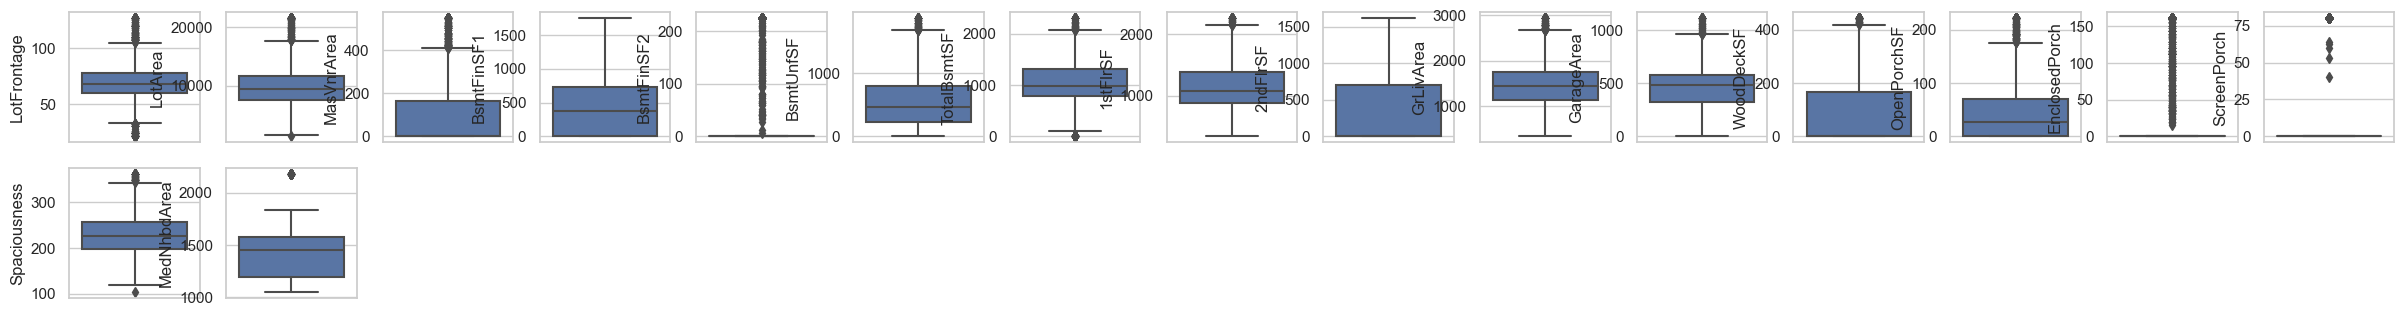

Shape after outlier correction  (2919, 82) rows & columns.


In [92]:
cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)
price_df[num_list].describe()

outlier_info=outliers(price_df,num_list)
display(outlier_info)

outlier_columns_fix=outlier_info[(outlier_info["Upper Limit"]>20) & (outlier_info.Outliers>0)]["Columns"]
display(list(outlier_columns_fix))

price_df=outlier_treatment(price_df,list(outlier_columns_fix))

Feature Engineering

MSSubClass MSZoning          LotFrontage              LotArea   
Id                                                                            
1   2-STORY 1946 & NEWER  RL                     65.00             8,450.00  \
2   1-STORY 1946 & NEWER  RL                     80.00             9,600.00   
3   2-STORY 1946 & NEWER  RL                     68.00            11,250.00   
4   2-STORY 1945 & OLDER  RL                     60.00             9,550.00   
5   2-STORY 1946 & NEWER  RL                     84.00            14,260.00   

   Street Alley LotShape LandContour Utilities LotConfig LandSlope   
Id                                                                   
1   Pave   NA    Reg      Lvl         AllPub    Inside    Gtl       \
2   Pave   NA    Reg      Lvl         AllPub    FR2       Gtl        
3   Pave   NA    IR1      Lvl         AllPub    Inside    Gtl        
4   Pave   NA    IR1      Lvl         AllPub    Corner    Gtl        
5   Pave   NA    IR1      Lvl         AllPub    FR2       Gtl        

   Neighborhood Condition1 Condition2 BldgType           HouseStyle   
Id                                                                    
1   CollgCr      Norm       Norm       1Fam                    2.00  \
2   Others       Feedr      Norm       1Fam                    1.00   
3   CollgCr      Norm       Norm       1Fam                    2.00   
4   Crawfor      Norm       Norm       1Fam                    2.00   
5   NoRidge      Norm       Norm       1Fam                    2.00   

    OverallQual  OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd   
Id                                                                        
1   7            5            Gable     CompShg  VinylSd     VinylSd     \
2   6            8            Gable     CompShg  MetalSd     MetalSd      
3   7            5            Gable     CompShg  VinylSd     VinylSd      
4   7            5            Gable     CompShg  Wd Sdng     Wd Shng      
5   8            5            Gable     CompShg  VinylSd     VinylSd      

   MasVnrType           MasVnrArea ExterQual ExterCond Foundation BsmtQual   
Id                                                                           
1   BrkFace                 196.00  Gd        TA        PConc      Gd       \
2   None                      0.00  TA        TA        CBlock     Gd        
3   BrkFace                 162.00  Gd        TA        PConc      Gd        
4   None                      0.00  TA        TA        BrkTil     TA        
5   BrkFace                 350.00  Gd        TA        PConc      Gd        

   BsmtCond BsmtExposure BsmtFinType1           BsmtFinSF1 BsmtFinType2   
Id                                                                        
1   TA       No           GLQ                       706.00  Unf          \
2   TA       Gd           ALQ                       978.00  Unf           
3   TA       Mn           GLQ                       486.00  Unf           
4   Gd       No           ALQ                       216.00  Unf           
5   TA       Av           GLQ                       655.00  Unf           

             BsmtFinSF2            BsmtUnfSF          TotalBsmtSF Heating   
Id                                                                          
1                  0.00               150.00               856.00  GasA    \
2                  0.00               284.00             1,262.00  GasA     
3                  0.00               434.00               920.00  GasA     
4                  0.00               540.00               756.00  GasA     
5                  0.00               490.00             1,145.00  GasA     

   HeatingQC CentralAir Electrical             1stFlrSF             2ndFlrSF   
Id                                                                             
1   Ex        Y          SBrkr                   856.00               854.00  \
2   Ex        Y          SBrkr                 1,262.00                 0.00   
3   Ex      

Shape after dervived columns  (2919, 81) rows & columns.


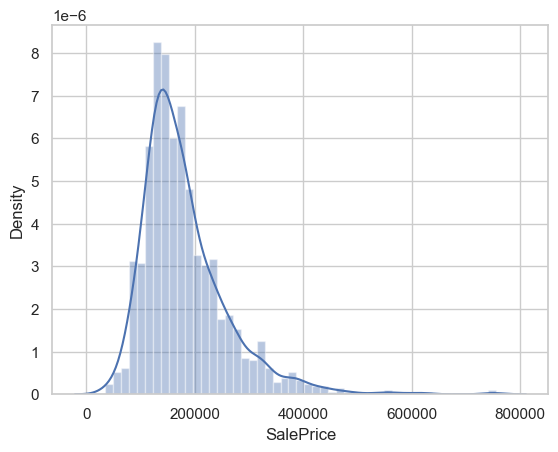

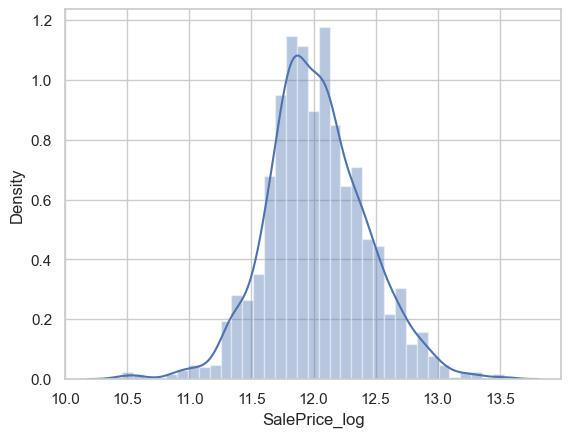

In [8]:
price_df["Age"]=price_df["YrSold"]-price_df["YearBuilt"]
price_df["GarageAge"]=price_df["YrSold"] - price_df["GarageYrBlt"]
price_df["GarageAge"].fillna(99,inplace=True)
price_df["LivLotRatio"] = price_df.GrLivArea / price_df.LotArea
price_df["Spaciousness"] = (price_df["1stFlrSF"] + price_df["2ndFlrSF"]) / price_df.TotRmsAbvGrd
price_df["MedNhbdArea"] = price_df.groupby("Neighborhood")["GrLivArea"].transform("median")
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Story',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Fin',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Unf',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Lvl',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('Foyer',''))
price_df["HouseStyle"]=price_df["HouseStyle"].apply(lambda x: x.replace('S','1'))
price_df["HouseStyle"]=price_df["HouseStyle"].astype('float64')
MSClass=[k for k,v in zip(list((price_df["MSSubClass"].value_counts()).index),
                          list((price_df["MSSubClass"].value_counts()).values)) if v<70]
Neig=[k for k,v in zip(list((price_df["Neighborhood"].value_counts()).index),
                       list((price_df["Neighborhood"].value_counts()).values)) if v<50]
price_df["MSSubClass"]=price_df["MSSubClass"].apply(lambda x: "Others" if x in MSClass else x)
price_df["Neighborhood"]=price_df["Neighborhood"].apply(lambda x: "Others" if x in Neig else x)
col_to_drop=["YrSold","YearBuilt","GarageYrBlt","YearRemodAdd"]
price_df.drop(col_to_drop,inplace=True,axis=1)
display(price_df.head())
print("Shape after dervived columns ",price_df.shape ,"rows & columns.")
x = price_df["SalePrice"]
sns.set_style("whitegrid")
sns.distplot(x)
plt.show()
price_df["SalePrice_log"] = np.log(price_df.SalePrice)
x = price_df.SalePrice_log
sns.distplot(x)
plt.show()

In [9]:
impute_columns = getMetadata(price_df)
impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
impute_columns.sort_values(by="Null_Count",ascending = False)

Datatype  Total_Element  Null_Count      Null_Percentage   
SalePrice      float64  1460           1459                      49.98  \
SalePrice_log  float64  1460           1459                      49.98   

               Unique_Value  
SalePrice      663           
SalePrice_log  663

Category Columns: ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']
Continous Columns: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', '

18

64

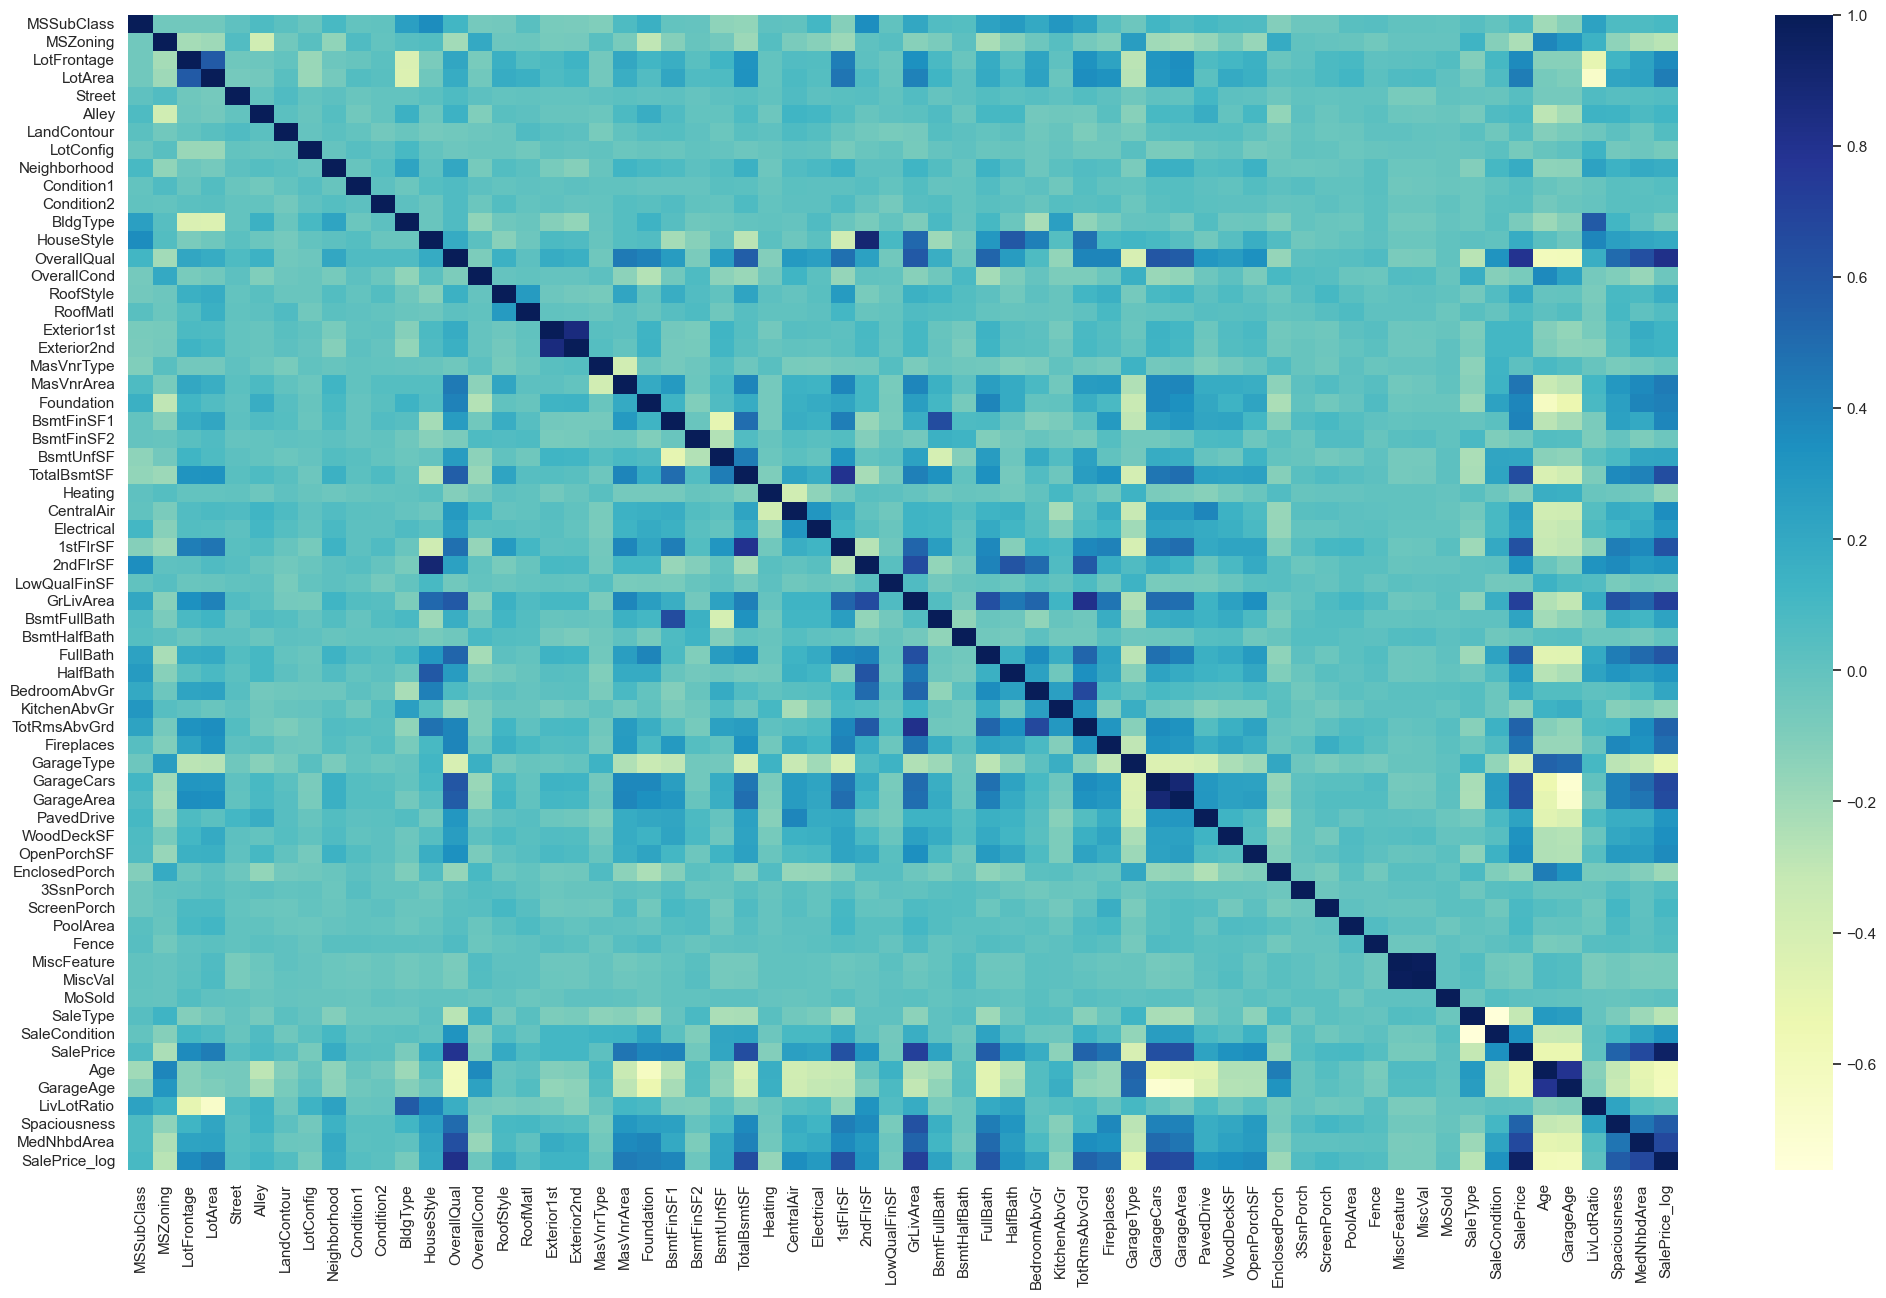

In [95]:
cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)
display(len(cat_list),len(num_list))
plt.figure(figsize = (25, 15))
sns.heatmap(price_df[num_list].corr(), annot = False, cmap="YlGnBu")
plt.show()

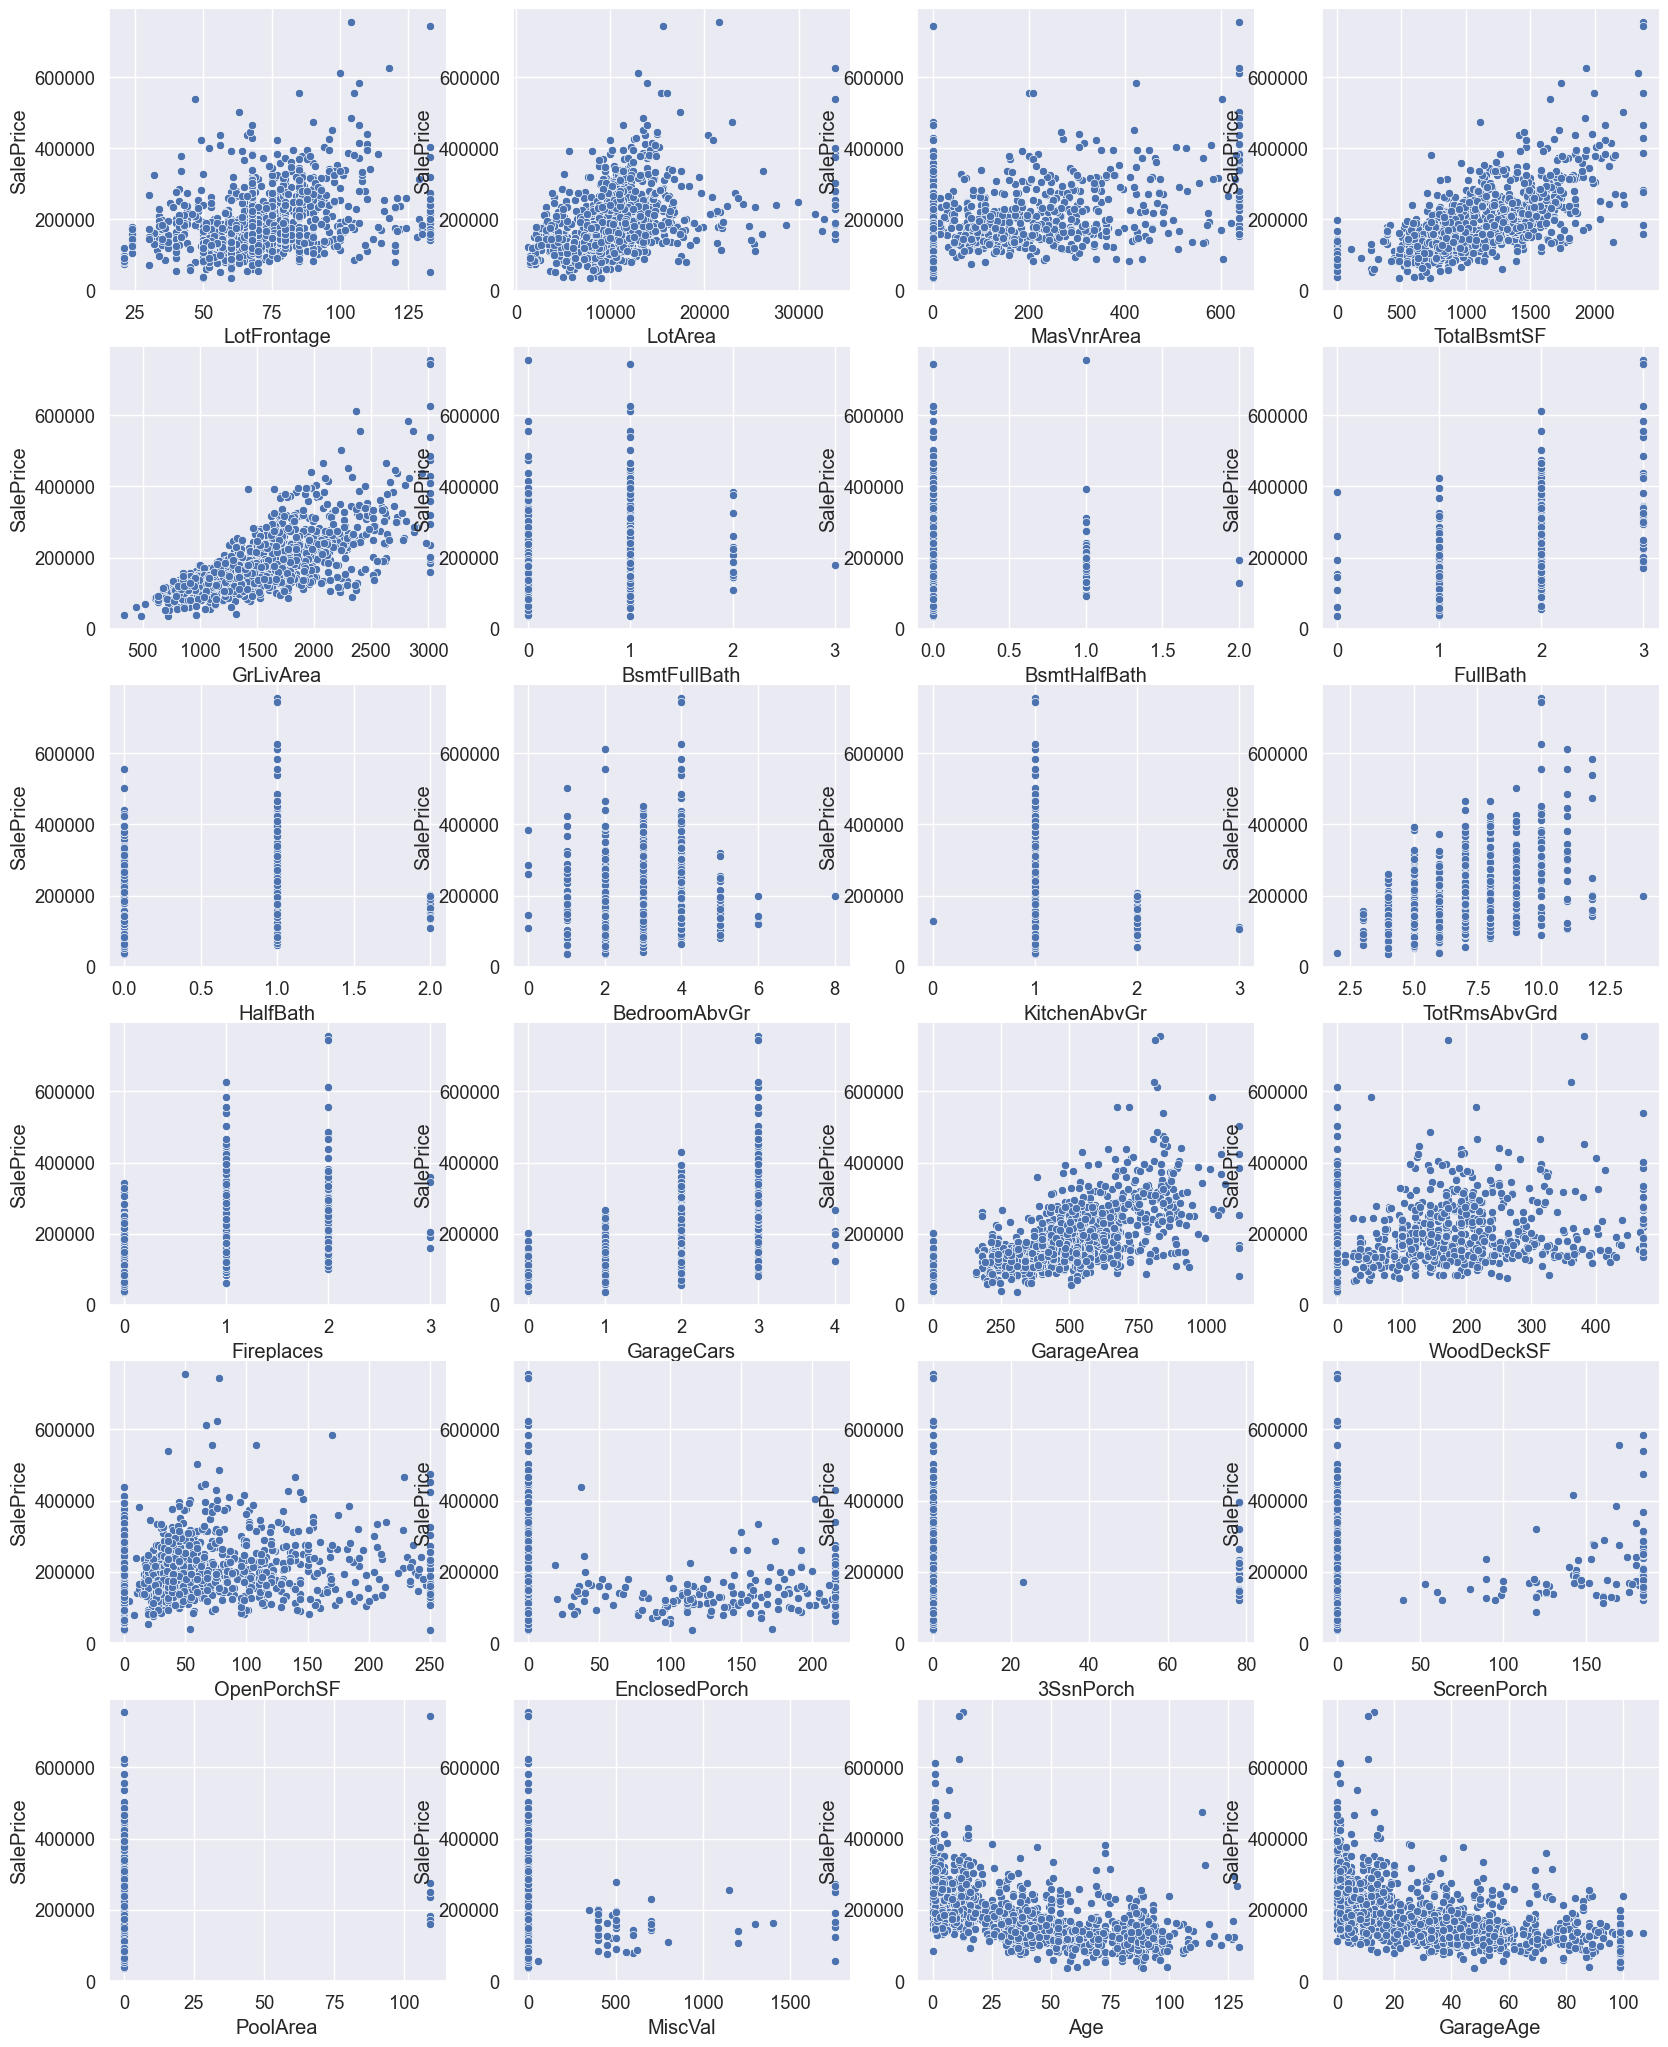

In [13]:
#### Visualising the continous columns columns
Quality_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','Age','GarageAge']
plt.figure(figsize=(20, 30))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(Quality_features):
    plt.subplot(7, 4, i+1)
    sns.scatterplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

<Figure size 1000x1000 with 0 Axes>

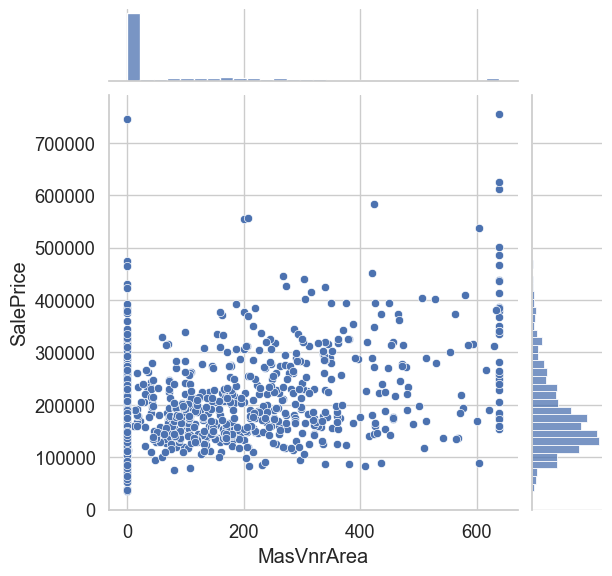

<Figure size 1000x1000 with 0 Axes>

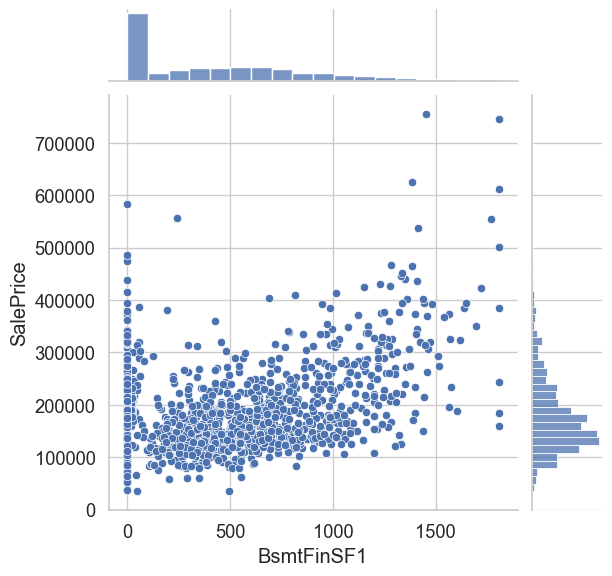

<Figure size 1000x1000 with 0 Axes>

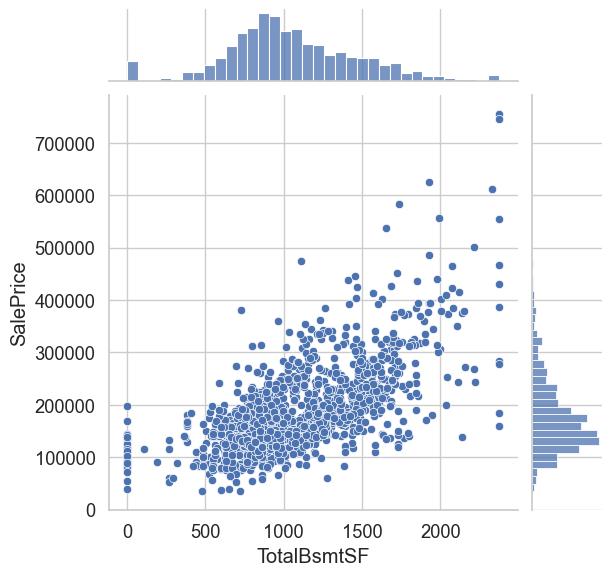

<Figure size 1000x1000 with 0 Axes>

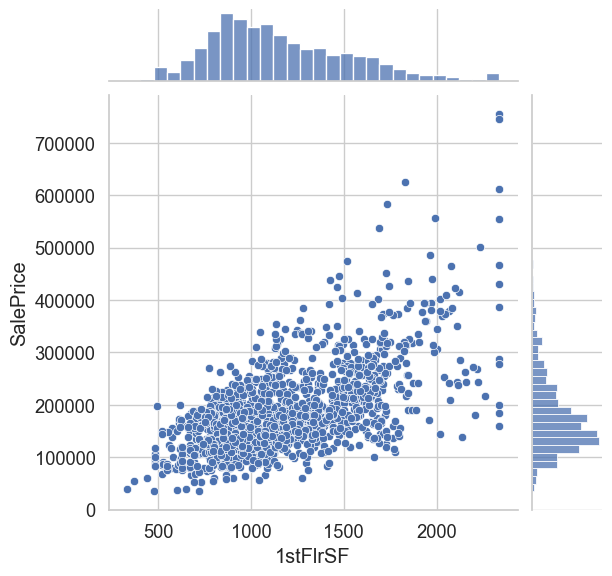

<Figure size 1000x1000 with 0 Axes>

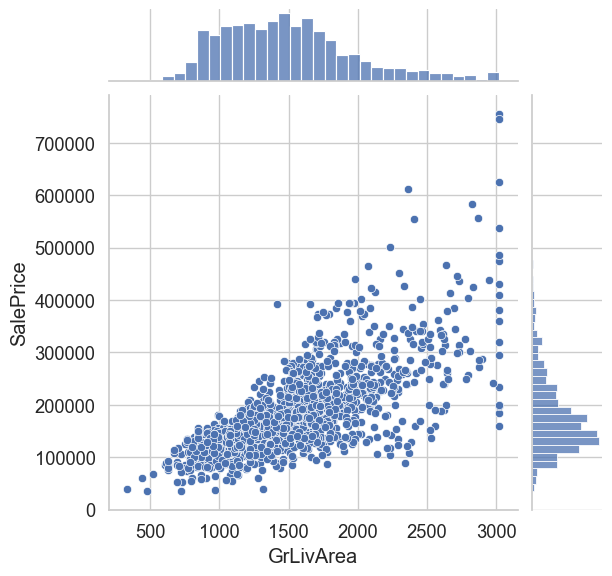

<Figure size 1000x1000 with 0 Axes>

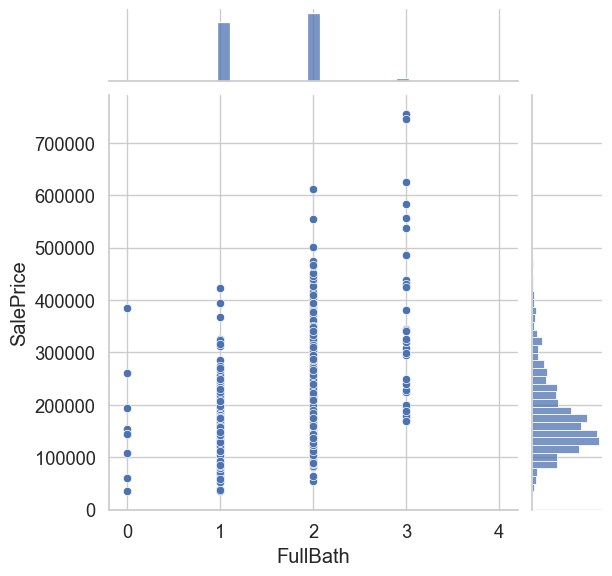

<Figure size 1000x1000 with 0 Axes>

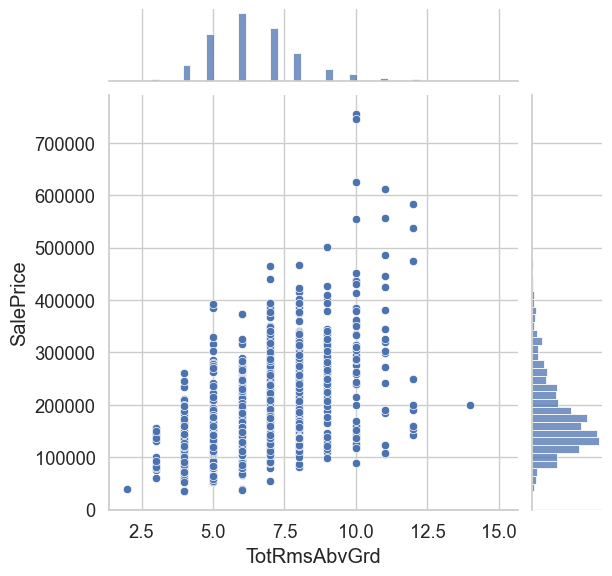

<Figure size 1000x1000 with 0 Axes>

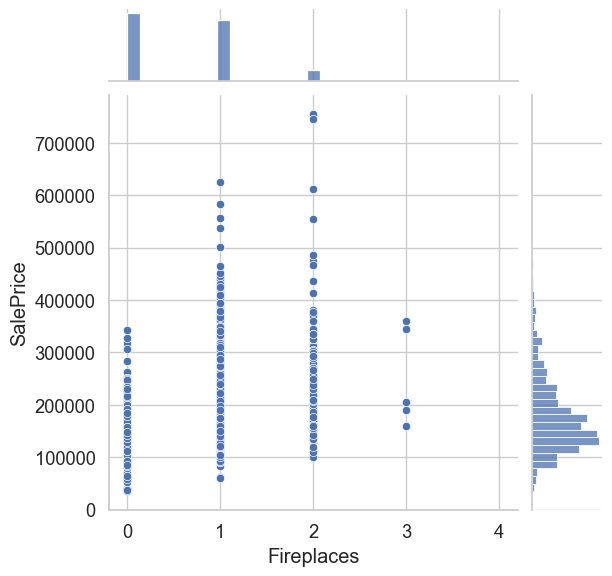

<Figure size 1000x1000 with 0 Axes>

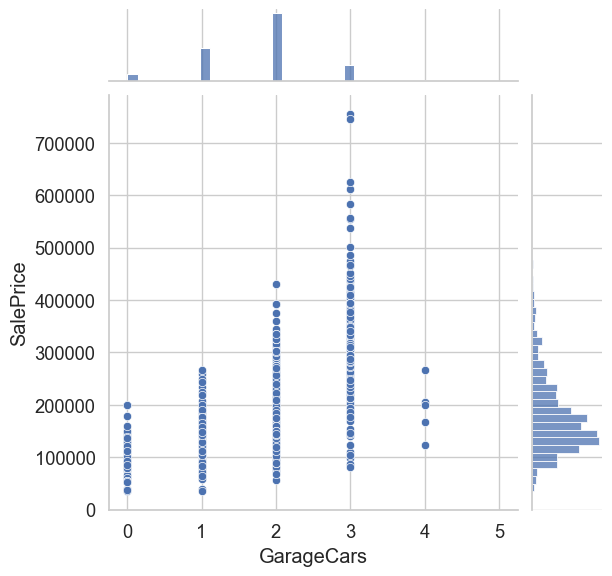

<Figure size 1000x1000 with 0 Axes>

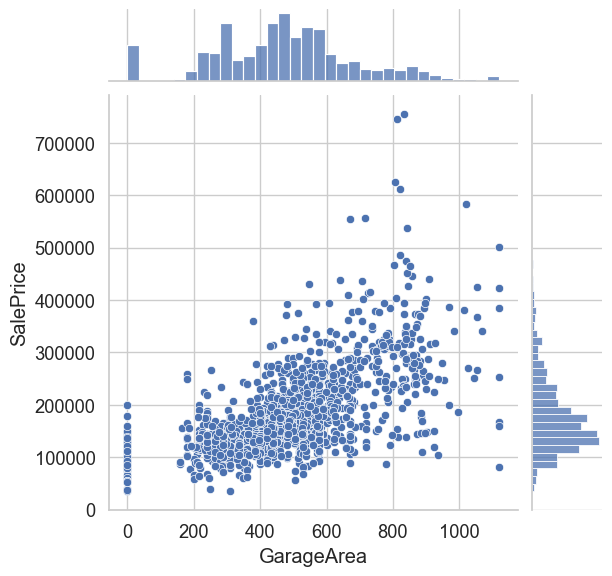

<Figure size 1000x1000 with 0 Axes>

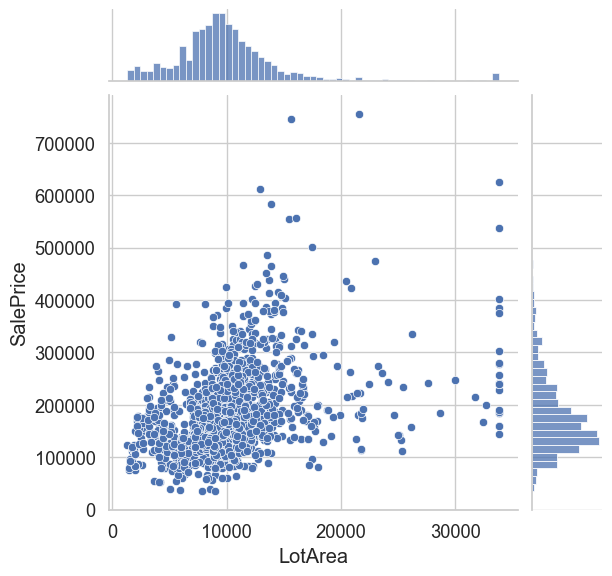

<Figure size 1000x1000 with 0 Axes>

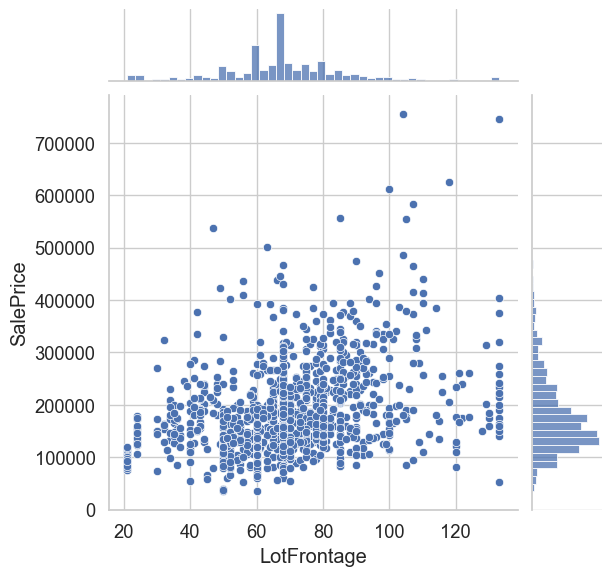

In [34]:
# We will plot some joint histogram and scatter grphs to look at correlated features in more detail
y = price_df["SalePrice"]
features = [
    "MasVnrArea",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "FullBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "LotArea",
    "LotFrontage",
]

for features in features:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 10))
    x = price_df[features]
    sns.jointplot(x=x, y=y, data=price_df)

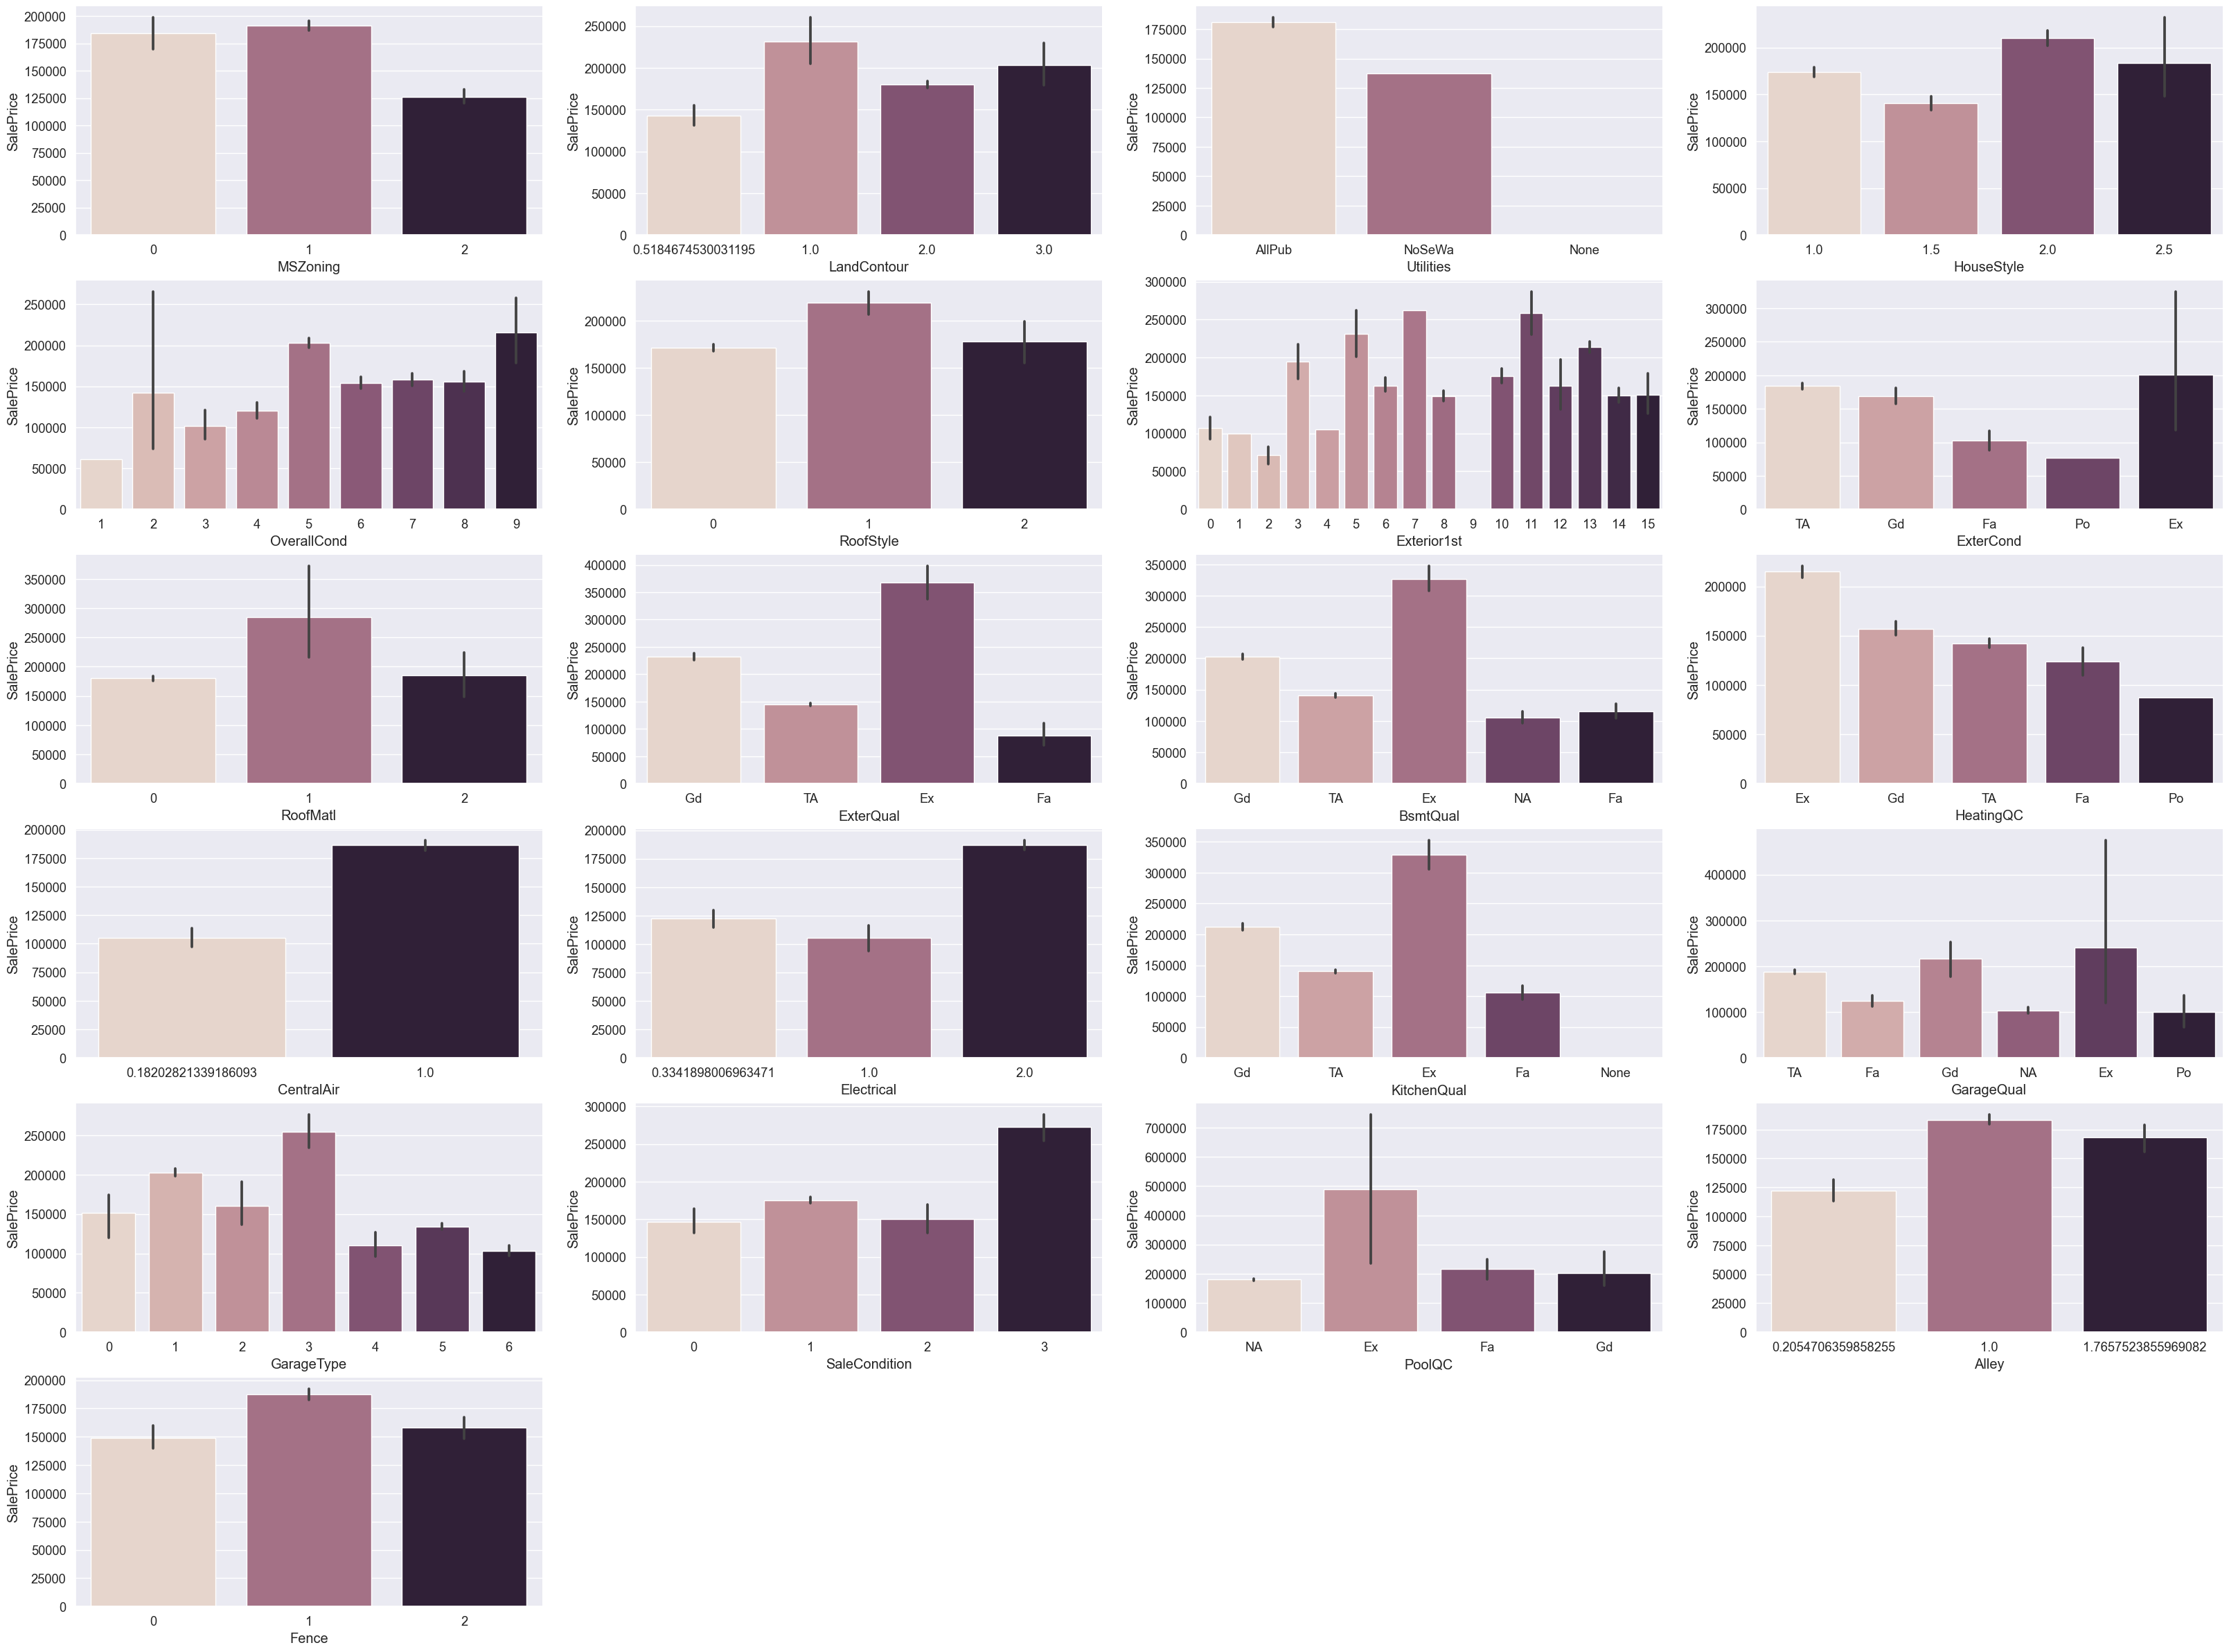

In [96]:
#### Visualising the categorical columns
Quality_features = ['MSZoning','LandContour','Utilities','HouseStyle','OverallCond','RoofStyle','Exterior1st','ExterCond',
                    'RoofMatl', 'ExterQual', 'BsmtQual', 'HeatingQC', 'CentralAir', 
                    'Electrical', 'KitchenQual', 'GarageQual','GarageType','SaleCondition','PoolQC','Alley','Fence']

plt.figure(figsize=(40, 30))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(Quality_features):
    plt.subplot(6, 4, i+1)
    sns.barplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

In [36]:
'''
features = price_df.select_dtypes(include=['object']).columns
plt.figure(figsize=(30, 20))
sns.set_style('darkgrid')

for feature in features:
    g = sns.FacetGrid(price_df[~price_df.SalePrice.isnull()], col=feature)
    g.map(plt.hist, 'SalePrice');
    sns.despine()
'''

"\nfeatures = price_df.select_dtypes(include=['object']).columns\nplt.figure(figsize=(30, 20))\nsns.set_style('darkgrid')\n\nfor feature in features:\n    g = sns.FacetGrid(price_df[~price_df.SalePrice.isnull()], col=feature)\n    g.map(plt.hist, 'SalePrice');\n    sns.despine()\n"

In [97]:
binn_col=['MSZoning','Street','Alley','LandContour',
'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Heating','CentralAir','Electrical',
'PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']
x=dict()
x["MSZoning"]=300
x["Street"]=10
x["Alley"]=60
x["LandContour"]=70
x["LandSlope"]=70
x["Condition1"]=100
x["Condition2"]=10
x["BldgType"]=120
x["RoofStyle"]=300
x["RoofMatl"]=15
x["Heating"]=20
x['Electrical']=100
x['Functional']=40
x['PavedDrive']=100
x['Fence']=160
x['MiscFeature']=50
x['SaleType']=130
x['SaleCondition']=130
for p,y in x.items():
    val=[k for k,v in zip(list((price_df[p].value_counts()).index),
                       list((price_df[p].value_counts()).values)) if v<y]
    price_df[p]=price_df[p].apply(lambda x: "Others" if x in val else x)
price_df.head()

MSSubClass MSZoning          LotFrontage              LotArea  Street   
Id                                                                          
1   5           1                      65.00             8,450.00  1       \
2   2           1                      80.00             9,600.00  1        
3   5           1                      68.00            11,250.00  1        
4   4           1                      60.00             9,550.00  1        
5   5           1                      84.00            14,260.00  1        

                  Alley LotShape          LandContour Utilities  LotConfig   
Id                                                                           
1                  1.00  Reg                     2.00  AllPub    4          \
2                  1.00  Reg                     2.00  AllPub    2           
3                  1.00  IR1                     2.00  AllPub    4           
4                  1.00  IR1                     2.00  AllPub    0           
5                  1.00  IR1                     2.00  AllPub    2           

   LandSlope  Neighborhood  Condition1  Condition2  BldgType   
Id                                                             
1   Gtl       1             1           1           0         \
2   Gtl       12            0           1           0          
3   Gtl       1             1           1           0          
4   Gtl       2             1           1           0          
5   Gtl       9             1           1           0          

             HouseStyle  OverallQual  OverallCond RoofStyle  RoofMatl   
Id                                                                      
1                  2.00  7            5            0         0         \
2                  1.00  6            8            0         0          
3                  2.00  7            5            0         0          
4                  2.00  7            5            0         0          
5                  2.00  8            5            0         0          

    Exterior1st  Exterior2nd  MasVnrType           MasVnrArea ExterQual   
Id                                                                        
1   13           14           1                        196.00  Gd        \
2   8            8            2                          0.00  TA         
3   13           14           1                        162.00  Gd         
4   14           16           2                          0.00  TA         
5   13           14           1                        350.00  Gd         

   ExterCond  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1   
Id                                                                     
1   TA        2           Gd       TA       No           GLQ          \
2   TA        1           Gd       TA       Gd           ALQ           
3   TA        2           Gd       TA       Mn           GLQ           
4   TA        0           TA       Gd       No           ALQ           
5   TA        2           Gd       TA       Av           GLQ           

             BsmtFinSF1 BsmtFinType2           BsmtFinSF2   
Id                                                          
1                706.00  Unf                         0.00  \
2                978.00  Unf                         0.00   
3                486.00  Unf                         0.00   
4                216.00  Unf                         0.00   
5                655.00  Unf                         0.00   

              BsmtUnfSF          TotalBsmtSF Heating HeatingQC   
Id                                                               
1                150.00               856.00  0       Ex        \
2                284.00             1,262.00  0       Ex         
3                434.00               920.00  0       Ex         
4                540.00               756.00  0       Gd         
5                490.00             1,145.00  0       Ex         

             CentralAir           

DATA PREPARATION

In [38]:
ordinal_feature=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond','LotShape', 'LandSlope', 'BsmtExposure', 
                 'BsmtFinType1', 'BsmtFinType2', 'Functional','GarageFinish','Utilities','PoolQC'
                 ]
nominal_feature= ["MSSubClass", "MSZoning", "Street", "LandContour", 
                "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", 
                 "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", 
                 "SaleType", "SaleCondition","PavedDrive",'Electrical','MoSold','Alley','Fence','MiscFeature']
df=encode(price_df,ordinal_feature,nominal_feature)

26

18

38

'Shape after dummy encoding '

(2919, 82)

'rows & columns.'

ExterQual_Fa  ExterQual_Gd  ExterQual_TA  ExterCond_Fa  ExterCond_Gd   
Id                                                                         
1   False         True          False         False         False         \
2   False         False         True          False         False          
3   False         True          False         False         False          
4   False         False         True          False         False          
5   False         True          False         False         False          

    ExterCond_Po  ExterCond_TA  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_NA   
Id                                                                      
1   False         True          False        True         False        \
2   False         True          False        True         False         
3   False         True          False        True         False         
4   False         True          False        False        False         
5   False         True          False        True         False         

    BsmtQual_TA  BsmtCond_Gd  BsmtCond_NA  BsmtCond_Po  BsmtCond_TA   
Id                                                                    
1   False        False        False        False        True         \
2   False        False        False        False        True          
3   False        False        False        False        True          
4   True         True         False        False        False         
5   False        False        False        False        True          

    HeatingQC_Fa  HeatingQC_Gd  HeatingQC_Po  HeatingQC_TA  KitchenQual_Fa   
Id                                                                           
1   False         False         False         False         False           \
2   False         False         False         False         False            
3   False         False         False         False         False            
4   False         True          False         False         False            
5   False         False         False         False         False            

    KitchenQual_Gd  KitchenQual_None  KitchenQual_TA  FireplaceQu_Fa   
Id                                                                     
1   True            False             False           False           \
2   False           False             True            False            
3   True            False             False           False            
4   True            False             False           False            
5   True            False             False           False            

    FireplaceQu_Gd  FireplaceQu_NA  FireplaceQu_Po  FireplaceQu_TA   
Id                                                                   
1   False           True            False           False           \
2   False           False           False           True             
3   False           False           False           True             
4   True            False           False           False            
5   False           False           False           True             

    GarageQual_Fa  GarageQual_Gd  GarageQual_NA  GarageQual_Po  GarageQual_TA   
Id                                                                              
1   False          False          False          False          True           \
2   False          False          False          False          True            
3   False          False          False          False          True            
4   False          False          False          False          True            
5   False          False          False          False          True            

    GarageCond_Fa  GarageCond_Gd  GarageCond_NA  GarageCond_Po  GarageCond_TA   
Id                                                                              
1   False          False          False          False          True           \
2   False          False          False          False          True            
3   False          False  

Shape after dummy encoding  (2919, 134) rows & columns.


SPLITTING & SCALING THE DATA

In [100]:
train=df[~df.SalePrice.isnull()]
test=df[df.SalePrice.isnull()]
display(train.shape,test.shape)

(1460, 134)

(1459, 134)

In [101]:
np.random.seed(0)
df_train, df_validation = train_test_split(train, train_size = 0.7, test_size = 0.3, random_state = 100)

In [102]:
X_train = df_train.drop(["SalePrice_log","SalePrice"], axis = 1)
y_train = df_train["SalePrice_log"]

X_validation = df_validation.drop(["SalePrice_log","SalePrice"], axis = 1)
y_validation = df_validation["SalePrice_log"]

X_test = test.drop(["SalePrice_log","SalePrice"], axis = 1)

In [103]:
num_list=list(X_train.select_dtypes(exclude=['object']).columns)

In [104]:
num_list.remove('LivLotRatio')

In [105]:
### Scaling
scaler = RobustScaler()
#scaler=StandardScaler()
X_train[num_list] = scaler.fit_transform(X_train[num_list])
X_validation[num_list] = scaler.transform(X_validation[num_list])
X_train.head()

ExterQual_Fa         ExterQual_Gd         ExterQual_TA   
Id                                                                    
211                  0.00                 0.00                 0.00  \
319                  0.00                 1.00                -1.00   
240                  0.00                 0.00                 0.00   
987                  0.00                 0.00                 0.00   
1417                 0.00                 0.00                 0.00   

             ExterCond_Fa         ExterCond_Gd         ExterCond_Po   
Id                                                                    
211                  0.00                 0.00                 0.00  \
319                  0.00                 0.00                 0.00   
240                  0.00                 0.00                 0.00   
987                  0.00                 1.00                 0.00   
1417                 0.00                 0.00                 0.00   

             ExterCond_TA          BsmtQual_Fa          BsmtQual_Gd   
Id                                                                    
211                  0.00                 0.00                 0.00  \
319                  0.00                 0.00                 1.00   
240                  0.00                 0.00                 0.00   
987                 -1.00                 0.00                 0.00   
1417                 0.00                 0.00                 0.00   

              BsmtQual_NA          BsmtQual_TA          BsmtCond_Gd   
Id                                                                    
211                  0.00                 1.00                 0.00  \
319                  0.00                 0.00                 0.00   
240                  0.00                 1.00                 0.00   
987                  0.00                 1.00                 0.00   
1417                 0.00                 1.00                 0.00   

              BsmtCond_NA          BsmtCond_Po          BsmtCond_TA   
Id                                                                    
211                  0.00                 0.00                 0.00  \
319                  0.00                 0.00                 0.00   
240                  0.00                 0.00                -1.00   
987                  0.00                 0.00                -1.00   
1417                 0.00                 0.00                 0.00   

             HeatingQC_Fa         HeatingQC_Gd         HeatingQC_Po   
Id                                                                    
211                  0.00                 0.00                 0.00  \
319                  0.00                 0.00                 0.00   
240                  0.00                 0.00                 0.00   
987                  0.00                 1.00                 0.00   
1417                 0.00                 1.00                 0.00   

             HeatingQC_TA       KitchenQual_Fa       KitchenQual_Gd   
Id                                                                    
211                  1.00                 0.00                 0.00  \
319                  0.00                 0.00                 1.00   
240                  1.00                 0.00                 0.00   
987                  0.00                 0.00                 1.00   
1417                 0.00                 0.00                 0.00   

         KitchenQual_None       KitchenQual_TA       FireplaceQu_Fa   
Id                                                                    
211                  0.00                 0.00                 0.00  \
319                  0.00                -1.00                 0.00   
240                  0.00                 0.00                 0.00   
987                  0.00                -1.00                 0.00   
1417                 0.00                 0.00                 0.00   

           FireplaceQu_Gd    

In [106]:
X_test[num_list]=scaler.transform(X_test[num_list])
X_test.head()

ExterQual_Fa         ExterQual_Gd         ExterQual_TA   
Id                                                                    
1461                 0.00                 0.00                 0.00  \
1462                 0.00                 0.00                 0.00   
1463                 0.00                 0.00                 0.00   
1464                 0.00                 0.00                 0.00   
1465                 0.00                 1.00                -1.00   

             ExterCond_Fa         ExterCond_Gd         ExterCond_Po   
Id                                                                    
1461                 0.00                 0.00                 0.00  \
1462                 0.00                 0.00                 0.00   
1463                 0.00                 0.00                 0.00   
1464                 0.00                 0.00                 0.00   
1465                 0.00                 0.00                 0.00   

             ExterCond_TA          BsmtQual_Fa          BsmtQual_Gd   
Id                                                                    
1461                 0.00                 0.00                 0.00  \
1462                 0.00                 0.00                 0.00   
1463                 0.00                 0.00                 1.00   
1464                 0.00                 0.00                 0.00   
1465                 0.00                 0.00                 1.00   

              BsmtQual_NA          BsmtQual_TA          BsmtCond_Gd   
Id                                                                    
1461                 0.00                 1.00                 0.00  \
1462                 0.00                 1.00                 0.00   
1463                 0.00                 0.00                 0.00   
1464                 0.00                 1.00                 0.00   
1465                 0.00                 0.00                 0.00   

              BsmtCond_NA          BsmtCond_Po          BsmtCond_TA   
Id                                                                    
1461                 0.00                 0.00                 0.00  \
1462                 0.00                 0.00                 0.00   
1463                 0.00                 0.00                 0.00   
1464                 0.00                 0.00                 0.00   
1465                 0.00                 0.00                 0.00   

             HeatingQC_Fa         HeatingQC_Gd         HeatingQC_Po   
Id                                                                    
1461                 0.00                 0.00                 0.00  \
1462                 0.00                 0.00                 0.00   
1463                 0.00                 1.00                 0.00   
1464                 0.00                 0.00                 0.00   
1465                 0.00                 0.00                 0.00   

             HeatingQC_TA       KitchenQual_Fa       KitchenQual_Gd   
Id                                                                    
1461                 1.00                 0.00                 0.00  \
1462                 1.00                 0.00                 1.00   
1463                 0.00                 0.00                 0.00   
1464                 0.00                 0.00                 1.00   
1465                 0.00                 0.00                 1.00   

         KitchenQual_None       KitchenQual_TA       FireplaceQu_Fa   
Id                                                                    
1461                 0.00                 0.00                 0.00  \
1462                 0.00                -1.00                 0.00   
1463                 0.00                 0.00                 0.00   
1464                 0.00                -1.00                 0.00   
1465                 0.00                -1.00                 0.00   

           FireplaceQu_Gd    

MODEL BUILDING & EVALUATION

Baseline Code

In [48]:
models=[LinearRegression(),Lasso(),Ridge()]
baseline(X_train,y_train,X_validation,y_validation,models)

Metric                Train                 Test
0  LR                    0.88                 0.83
1  Lasso                 0.02                -0.02
2  Ridge                 0.88                 0.84

LINEAR REGRESSION

Time taken to predict train and test 0.006979942321777344 sec


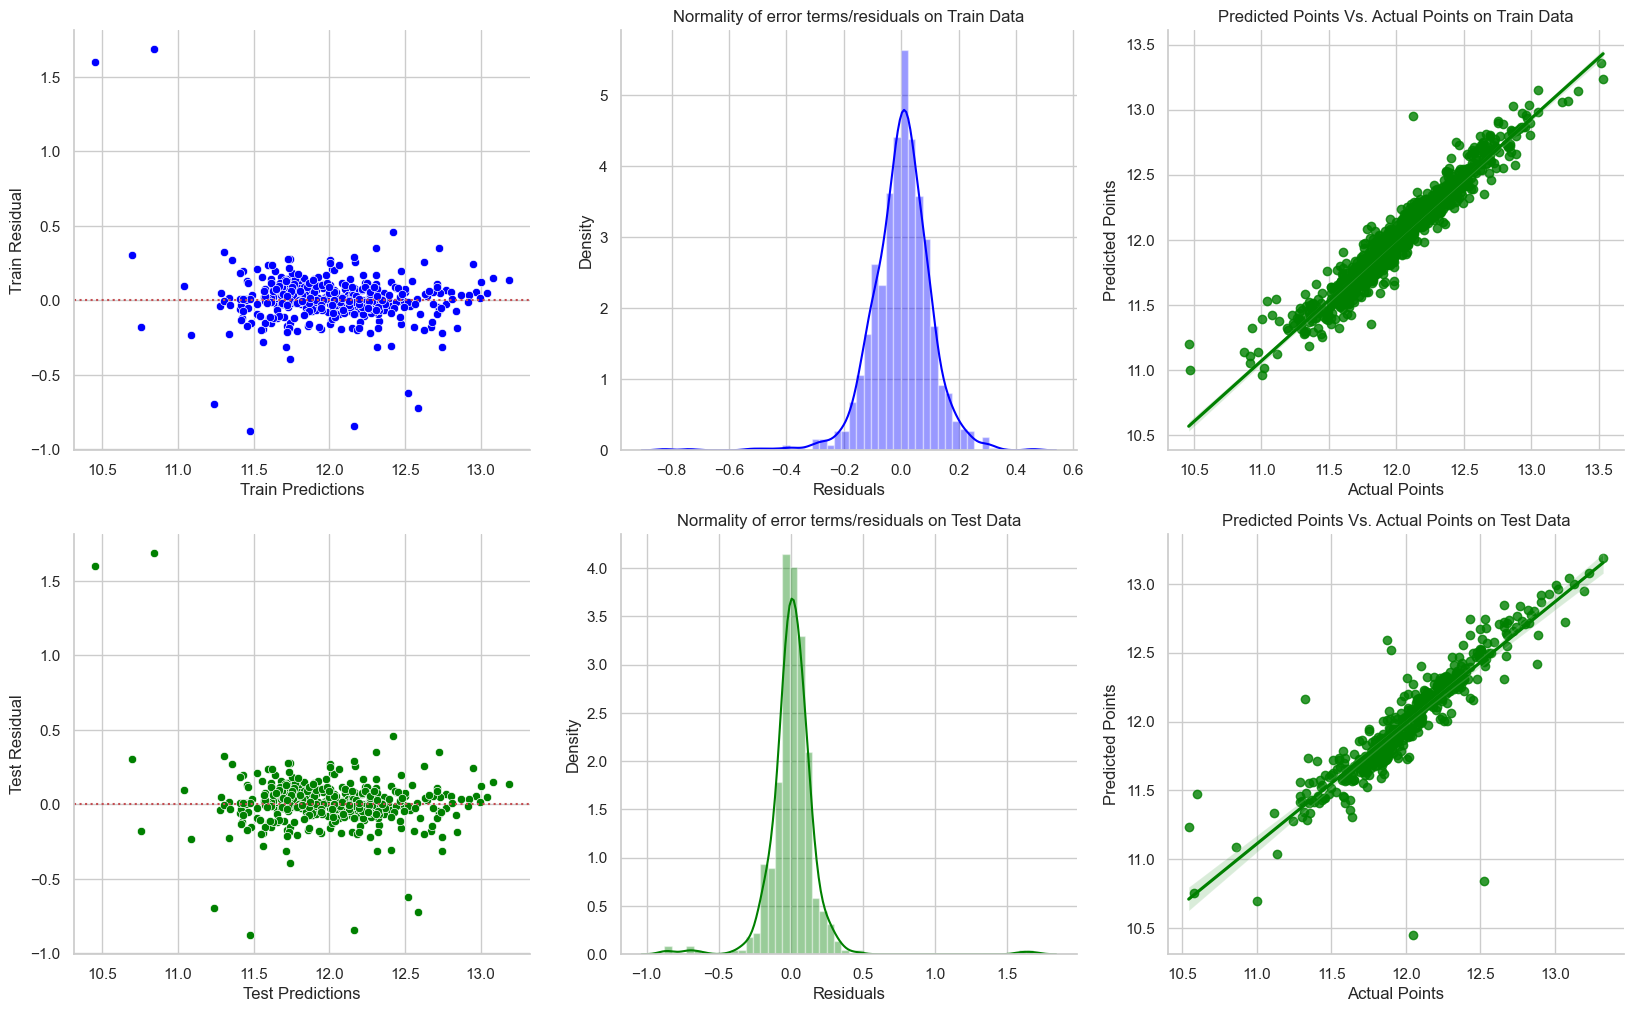

In [49]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_metric=prediction_matrix(lm,X_train,X_validation,y_train,y_validation)

Optimal number of features : 65


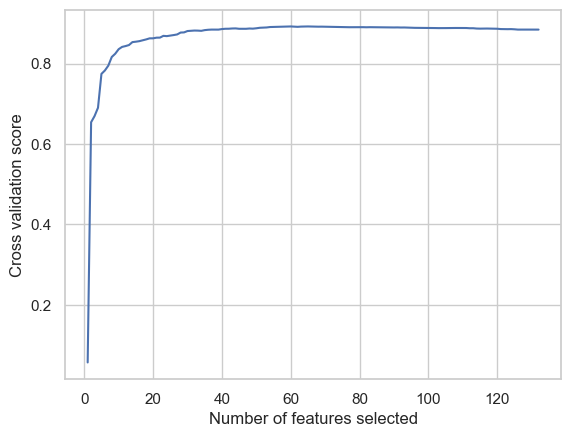

In [50]:
#cross_validation(X_train,y_train,lm)
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=Ridge(), step=1, cv=10,
              scoring='r2',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(min_features_to_select,
               len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
         rfecv.cv_results_['mean_test_score'])
plt.show()

Time taken to predict train and test 0.0049860477447509766 sec


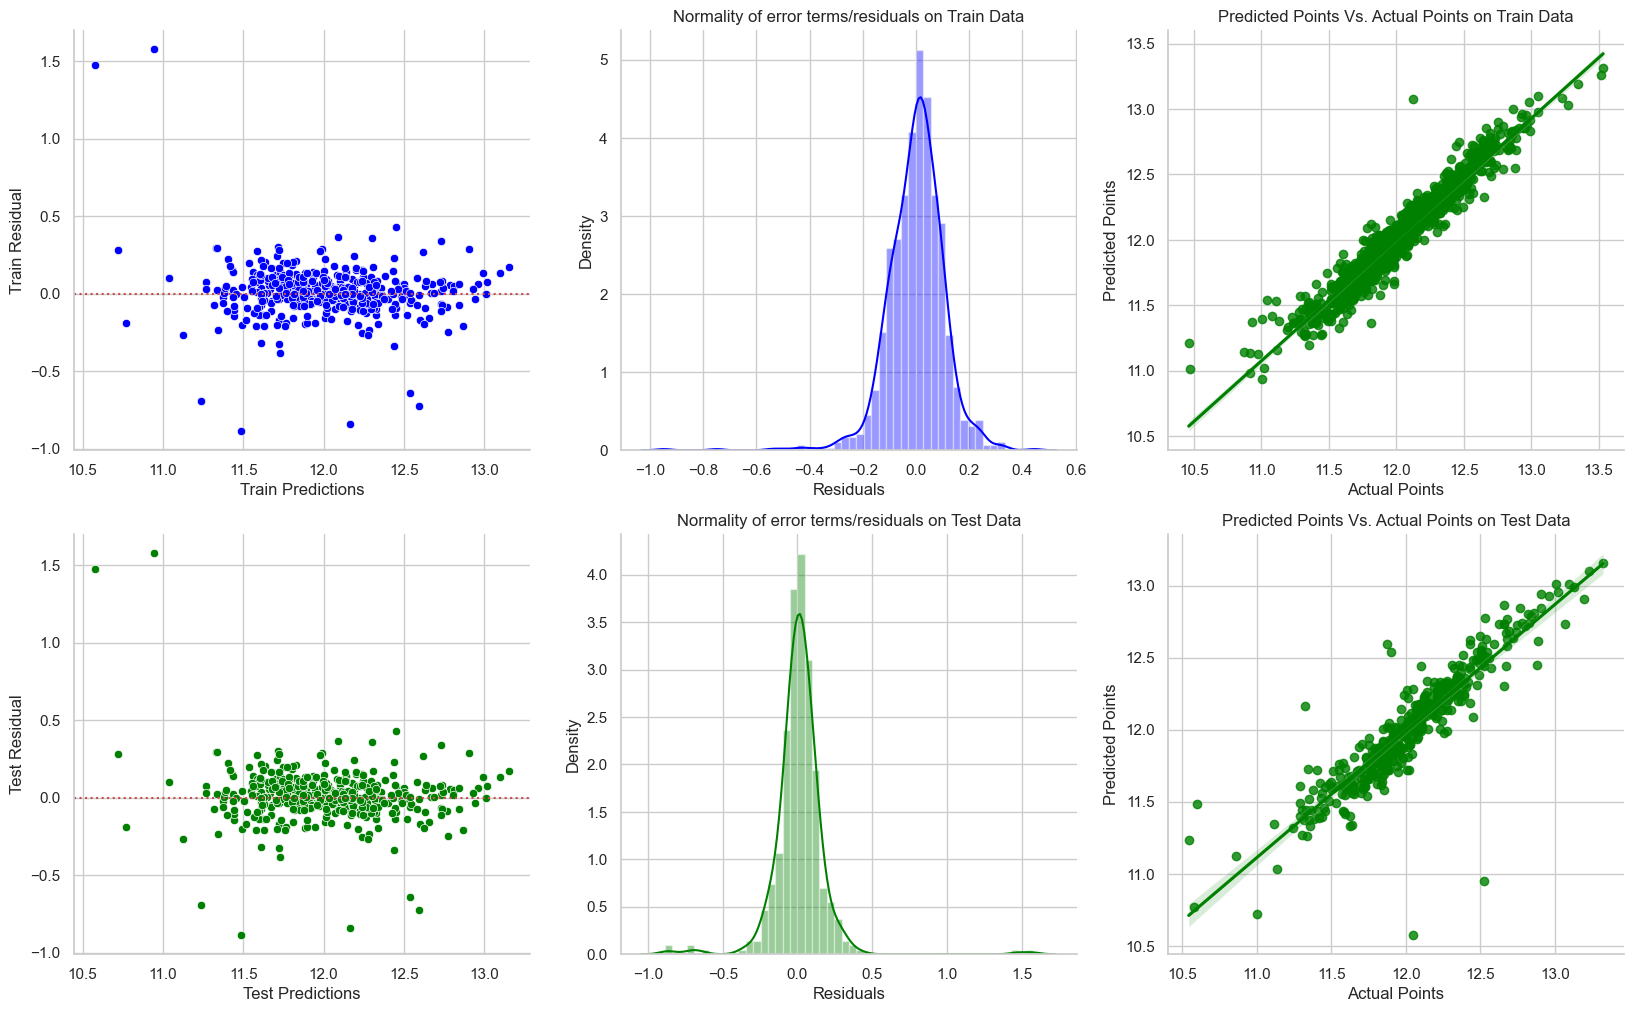

In [51]:
### selecting columns post rfe
col = X_train.columns[rfecv.support_]
len(list(col))
X_train_rfe = X_train[col]
X_validation_rfe  = X_validation[col]
lm_rfe=LinearRegression()
lm_rfe.fit(X_train_rfe,y_train)
lm_rfe_metric=prediction_matrix(lm_rfe,X_train_rfe,X_validation_rfe,y_train,y_validation)

Ridge Regression

Fitting 5 folds for each of 11 candidates, totalling 55 fits


{'alpha': 1.0}

Time taken to predict train and test 0.003988742828369141 sec


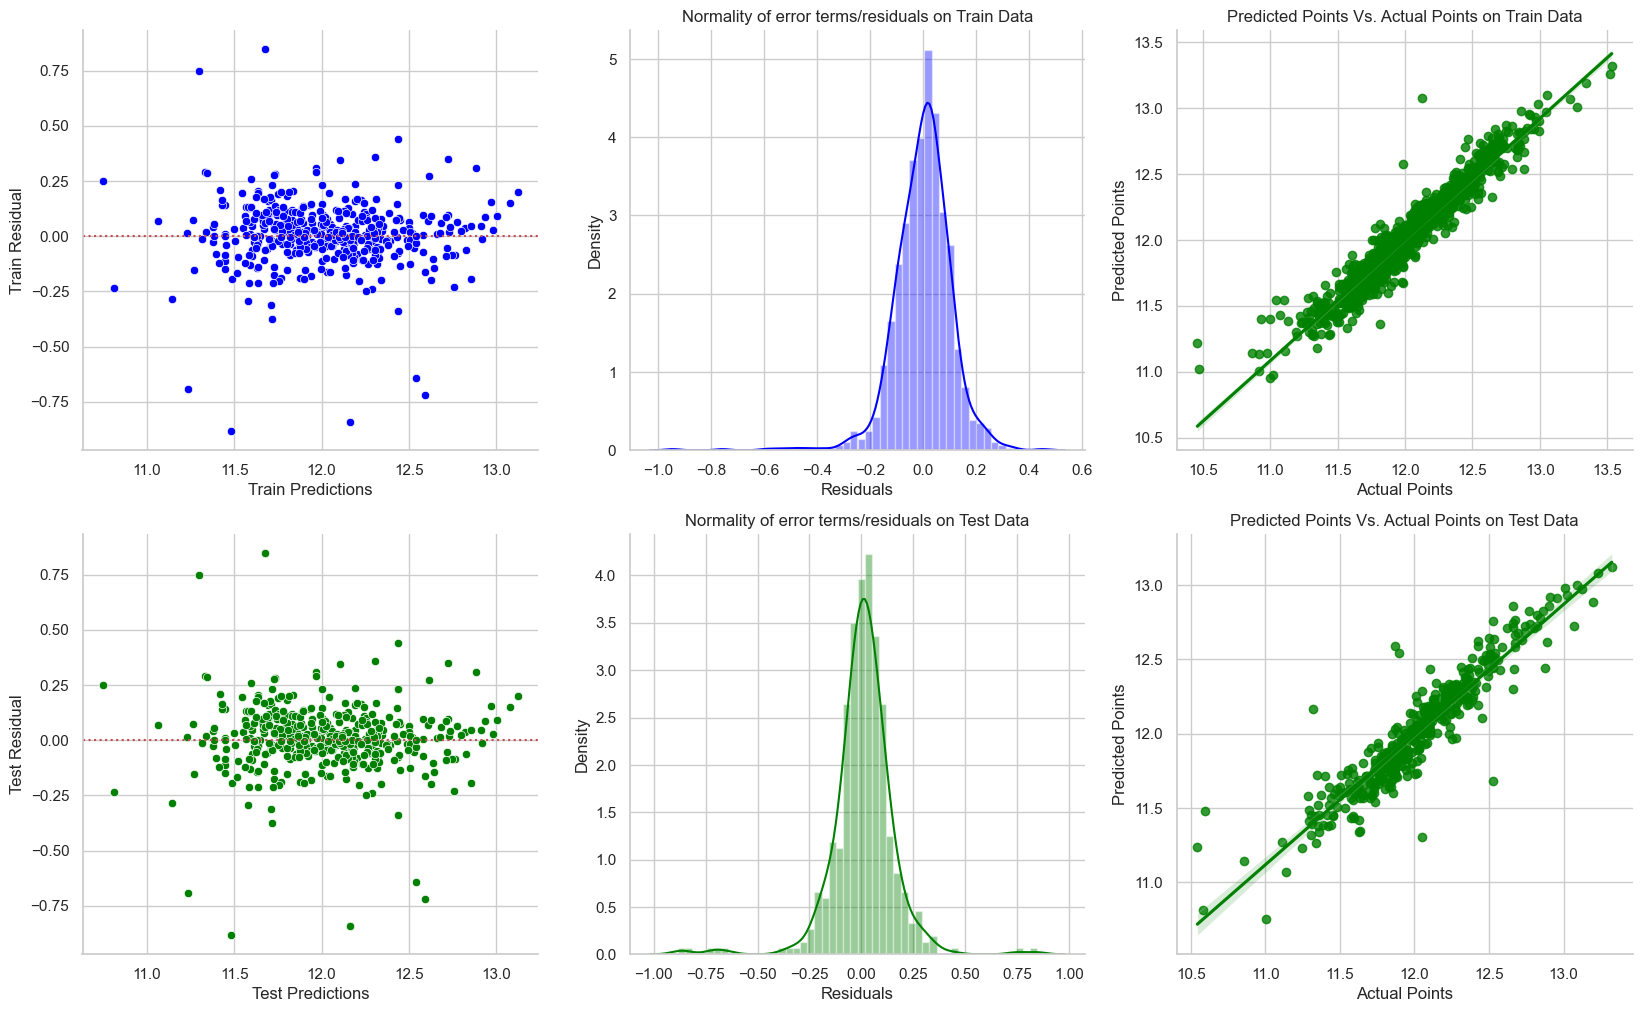

In [52]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.001, 0.01, 0.1, 1.0,10.0,20,50,100,150,200,500]}
estimator = Ridge()
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 
display(model_cv.best_params_)
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_rfe, y_train)
lm_ridge_metric=prediction_matrix(ridge,X_train_rfe,X_validation_rfe,y_train,y_validation)

Lasso Regression

Fitting 5 folds for each of 13 candidates, totalling 65 fits


{'alpha': 0.001}

Time taken to predict train and test 0.008975982666015625 sec


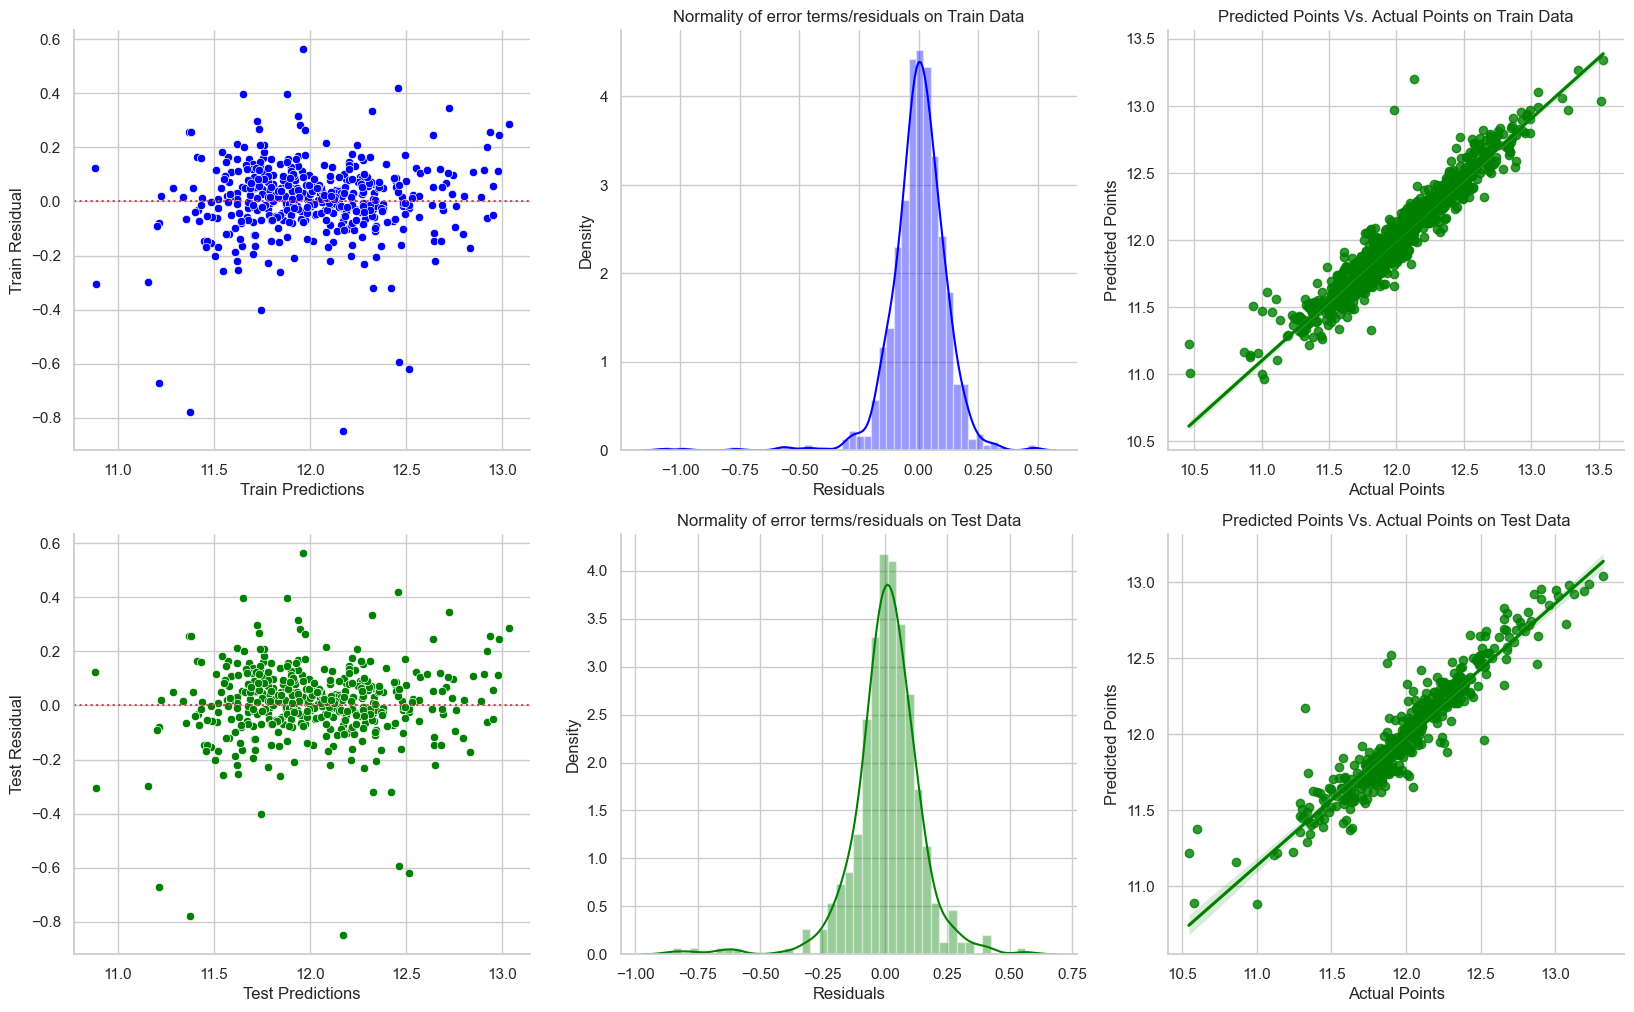

In [53]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.00001,0.0001,0.001, 0.01, 0.1, 1.0,10.0,20,50,100,150,200,500]}
#params = {'alpha': [0.001, 0.0001, 0.0005, 0.005,0.003 ]}
estimator = Lasso()
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
display(model_cv.best_params_)
alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 
lm_lasso_metric=prediction_matrix(lasso,X_train,X_validation,y_train,y_validation)

Decision Tree

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)

Time taken to predict train and test 0.009975671768188477 sec


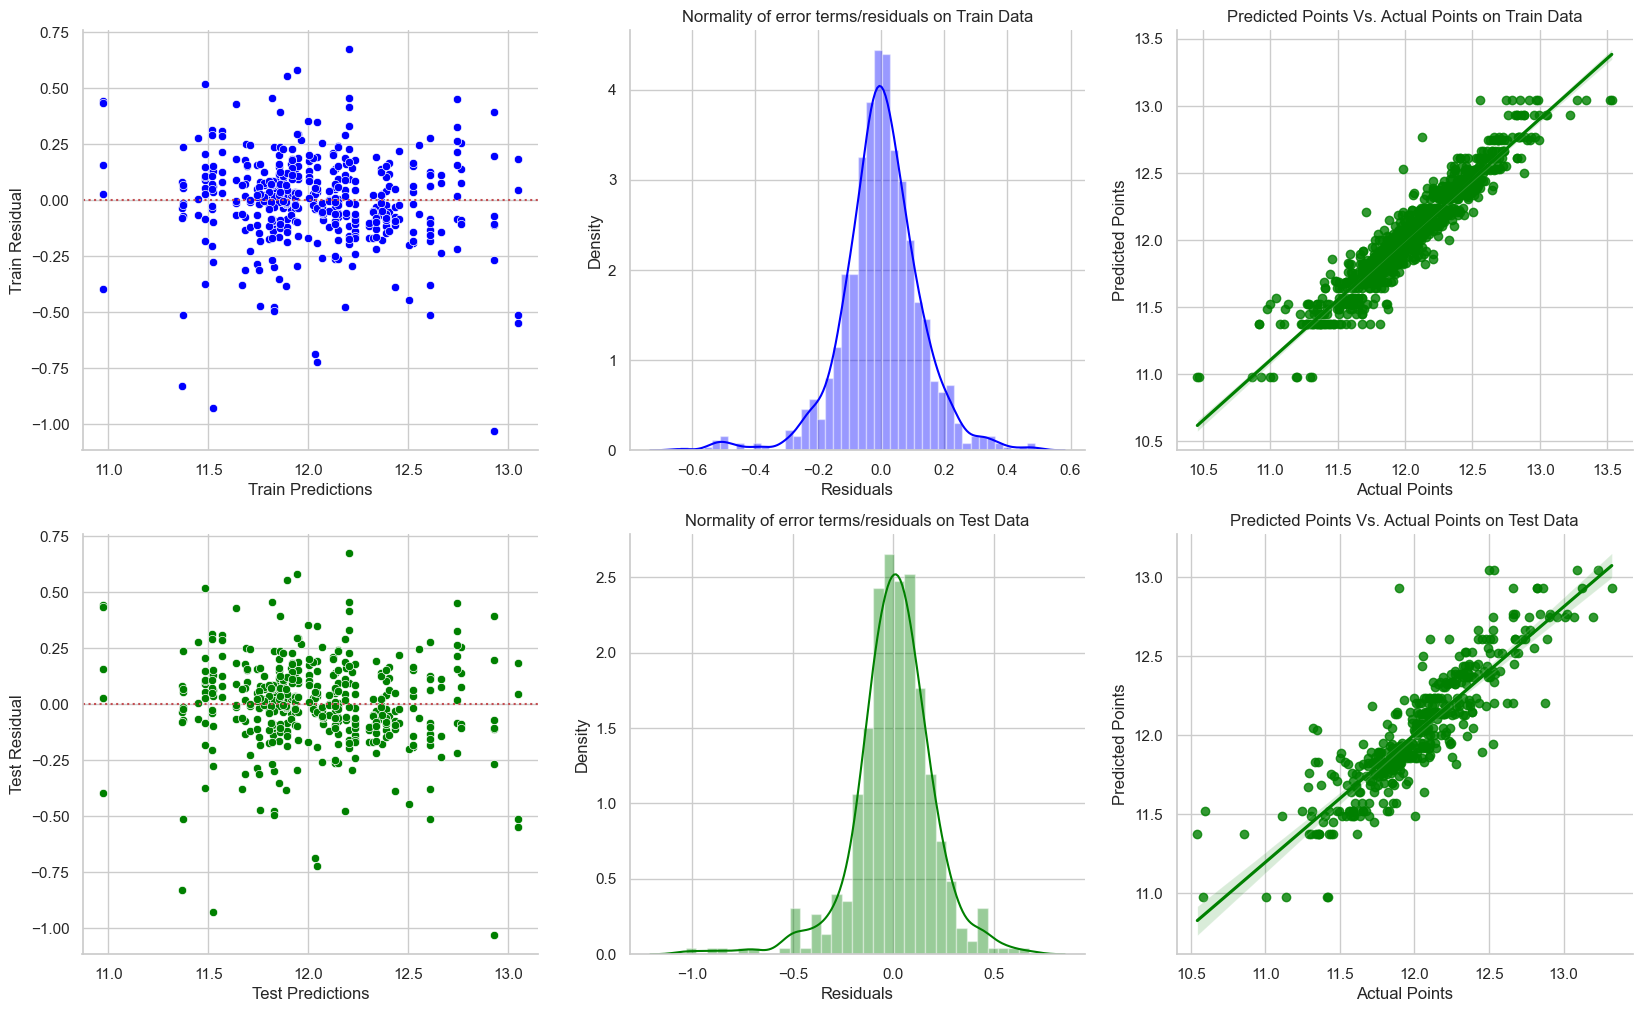

In [57]:
params = {
    #'criterion':['mse'],
    'splitter':['best'],
    'max_depth':[5,10,15,20,40,50],
    'min_samples_split':[2,5,10,20,50,100],
    'min_samples_leaf':[1,2,3,5,10,20],
    'random_state':[42,100],
}
from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor(criterion='squared_error', random_state=42)
# cross validation
folds = 5
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=False,
                        verbose = 1)  
model_cv.fit(X_train, y_train)
display(model_cv.best_estimator_)
lm_dt=model_cv.best_estimator_
lm_dt.fit(X_train, y_train) 
lm_dt_metric=prediction_matrix(lm_dt,X_train,X_validation,y_train,y_validation)

Random Forest

Fitting 3 folds for each of 216 candidates, totalling 648 fits


RandomForestRegressor(max_depth=15, max_features=50, min_samples_leaf=3,
                      min_samples_split=5, n_jobs=-1, oob_score=True,
                      random_state=42)

Time taken to predict train and test 0.044583797454833984 sec


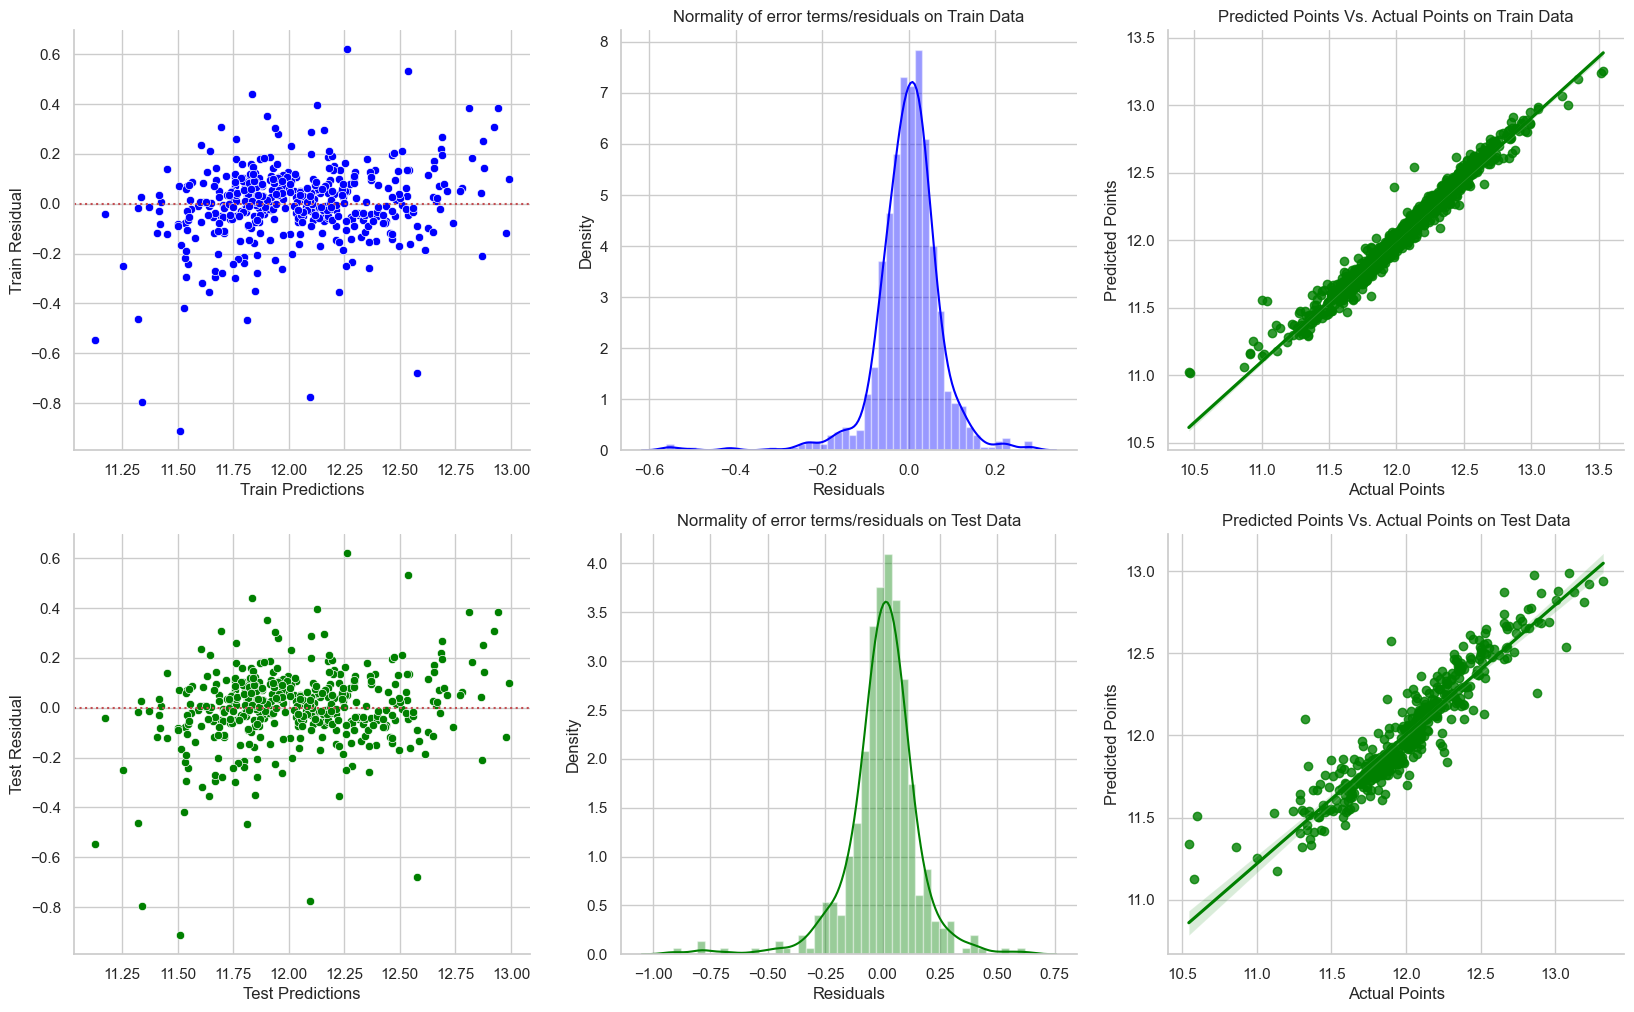

In [59]:
params = {
    #'criterion':['mse'],
    'max_depth':[5,10,15,20],
    'min_samples_split':[5,10],
    'min_samples_leaf':[3,5,10],
  #  'random_state':[42,100],
    'max_features': [50,75,140],
    'n_estimators':[30,50,100],
    'n_jobs':[-1],
    'oob_score':[True]
    
}
estimator = RandomForestRegressor(criterion='squared_error', random_state=42)
# cross validation
folds = 3
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=False,
                        verbose = 1)  
model_cv.fit(X_train, y_train) 
display(model_cv.best_estimator_)
lm_rfc=model_cv.best_estimator_
lm_rfc.fit(X_train, y_train) 
lm_rfc_metric=prediction_matrix(lm_rfc,X_train,X_validation,y_train,y_validation)

KKN Regression

Time taken to predict train and test 0.18448114395141602 sec


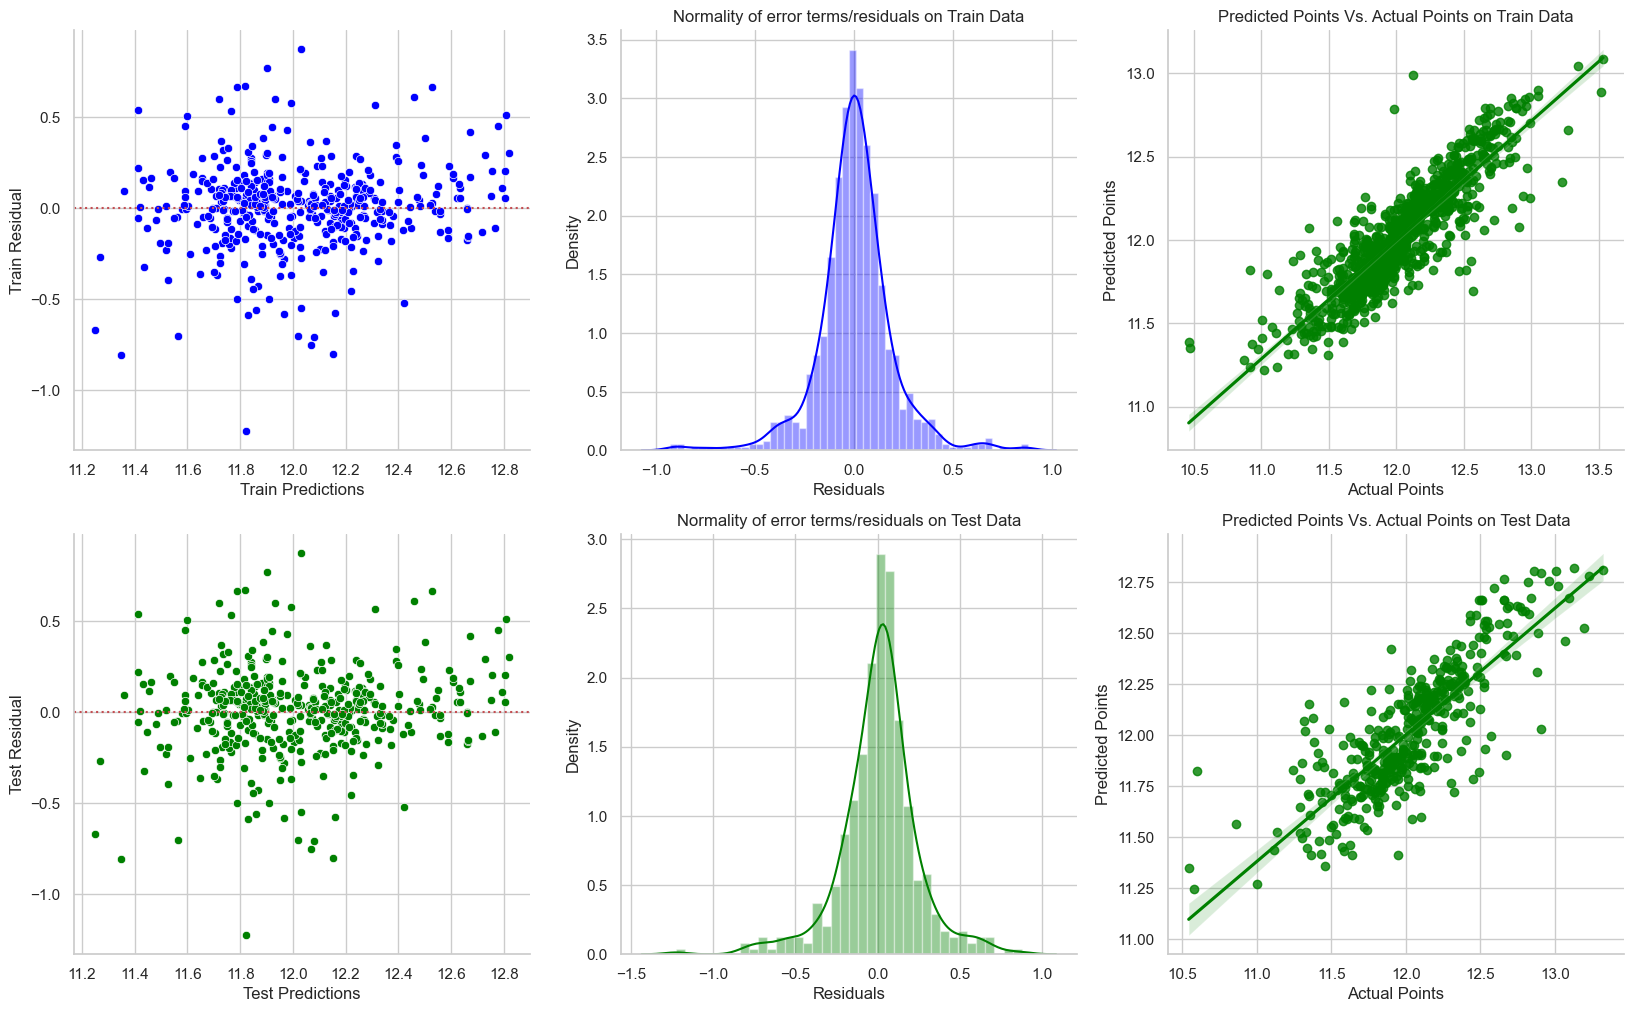

In [60]:
lm_knn=KNeighborsRegressor(n_neighbors=5)
lm_knn.fit(X_train, y_train) 
lm_knn_metric=prediction_matrix(lm_knn,X_train,X_validation,y_train,y_validation)

Gradient Boosting

Time taken to predict train and test 0.016954660415649414 sec


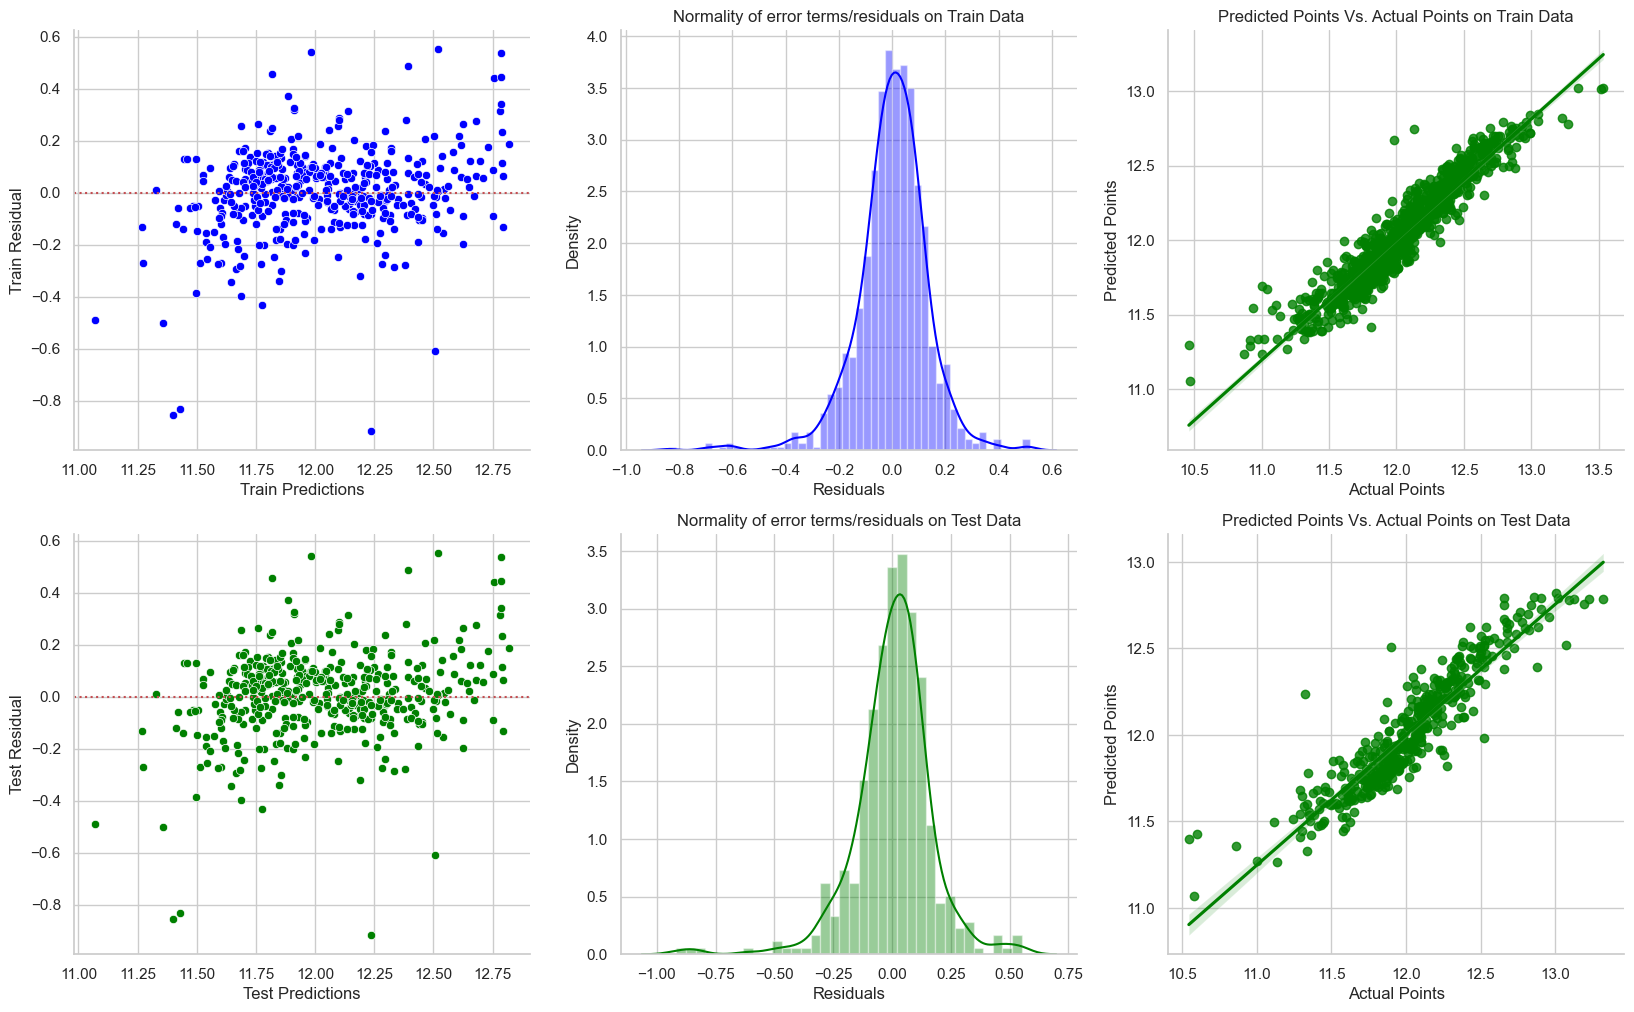

In [61]:
lm_gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=31)
lm_gbr.fit(X_train, y_train) 
lm_gbr_metric=prediction_matrix(lm_gbr,X_train,X_validation,y_train,y_validation)

XGBRegressor

Fitting 3 folds for each of 36 candidates, totalling 108 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=1,
             predictor=None, random_state=None, ...)

Time taken to predict train and test 0.04089069366455078 sec


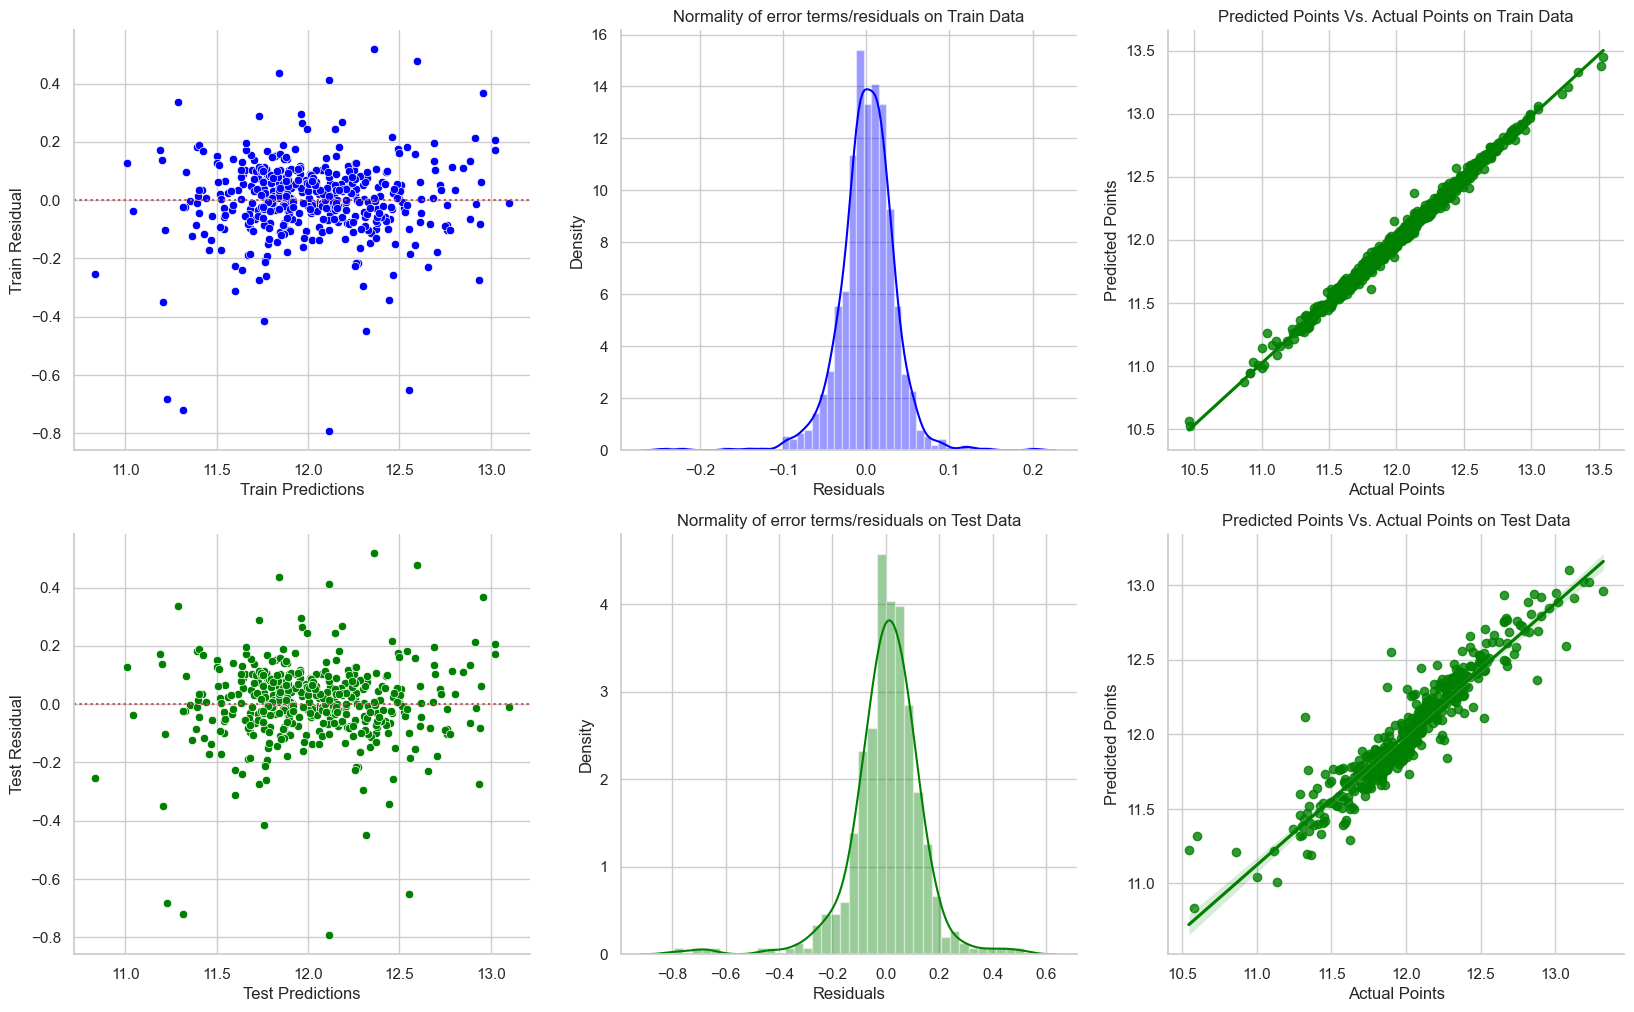

In [63]:
params = dict(
    max_depth=[3,9] ,          # maximum depth of each tree - try 2 to 10
    learning_rate=[0.01] ,   # effect of each tree - try 0.0001 to 0.1
    n_estimators=[1000] ,    # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=[1,5] ,   # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=[0.7],  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=[0.7],         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=[0,5,10],         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=[1,5,8]  ,      # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=[1],   # set > 1 for boosted random forests
)
estimator = XGBRegressor()
# cross validation
folds = 3
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=False,
                        verbose = 1)  
model_cv.fit(X_train, y_train) 
display(model_cv.best_estimator_)
lm_xgb = model_cv.best_estimator_
lm_xgb.fit(X_train, y_train) 
lm_xgb_metric=prediction_matrix(lm_xgb,X_train,X_validation,y_train,y_validation)

Stacked Regression

Time taken to predict train and test 0.23337650299072266 sec


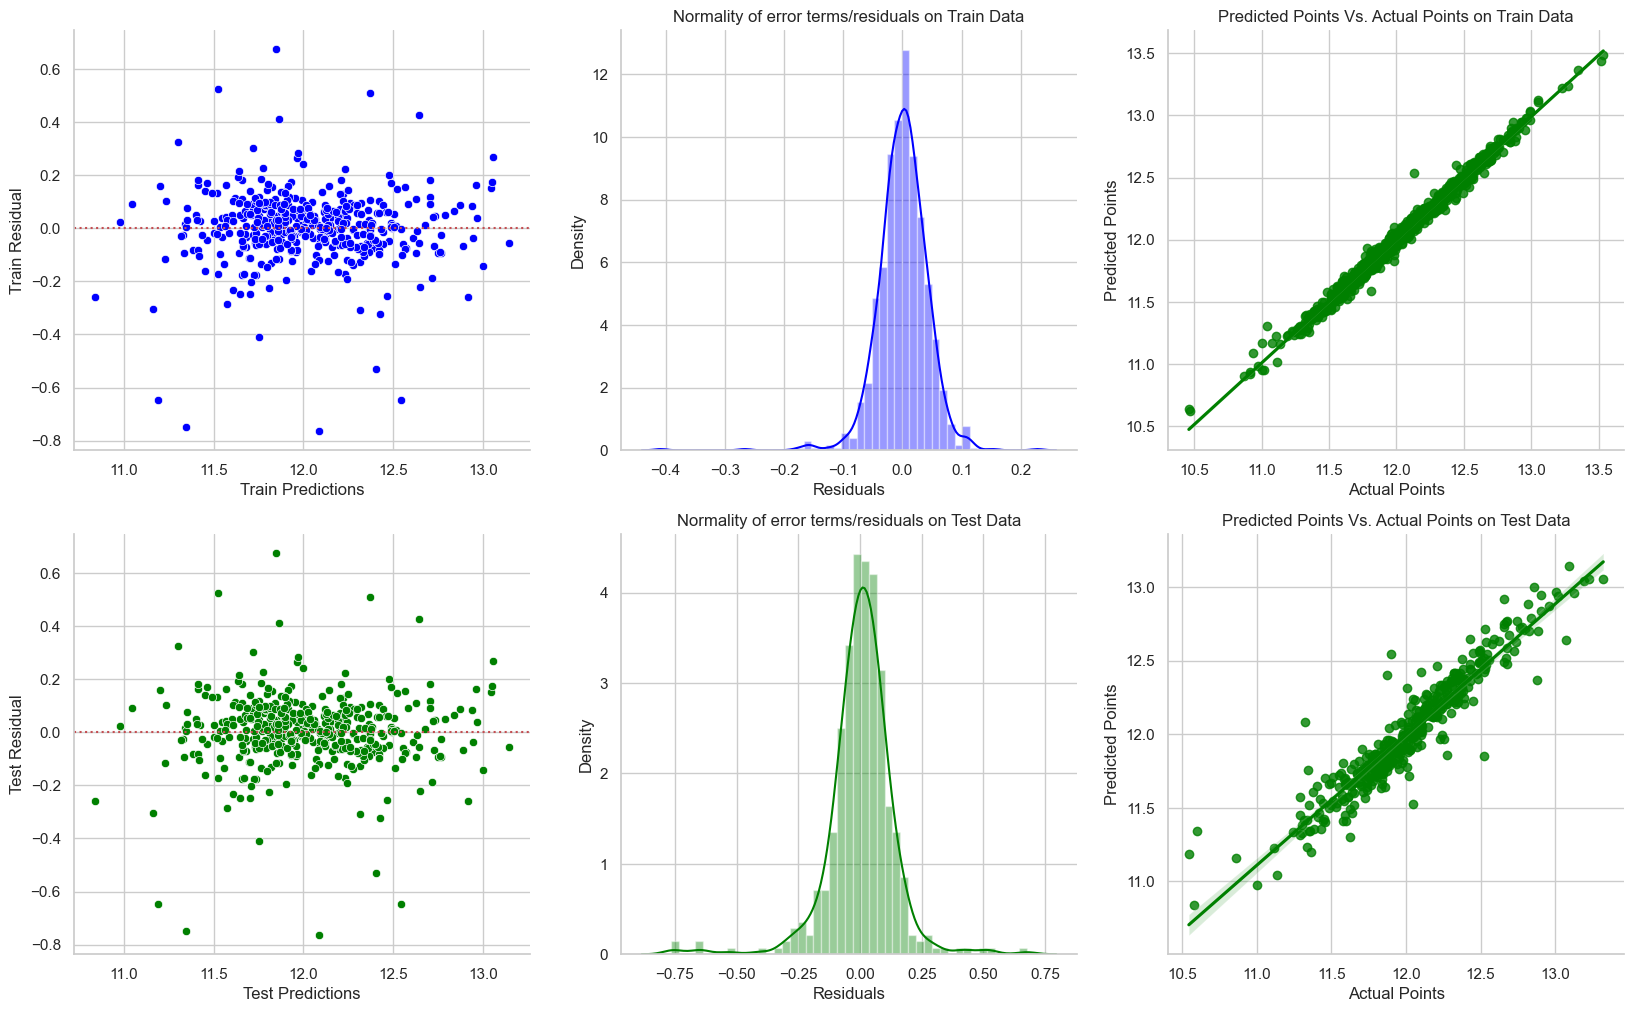

In [65]:
estimators = [
    ('lr', lm),
    ("lasso",lasso),
    ('ridge',ridge),
    ('dt',lm_dt),
    ('rfc',lm_rfc),
    ('gbr',lm_gbr),
    ('xgb',lm_xgb)
]
lm_stack = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())
lm_stack.fit(X_train, y_train)
lm_stack_metric=prediction_matrix(lm_stack,X_train,X_validation,y_train,y_validation)

In [73]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','Adjusted R2 Score (Train)','Adjusted R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': lm_metric
        }

metric_lm = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
metric_lm_rfe = pd.Series(lm_rfe_metric,name = 'RFE Linear Regression')
metric_lm_ridge = pd.Series(lm_ridge_metric, name = 'Ridge Regression')
metric_lm_lasso = pd.Series(lm_lasso_metric, name = 'Lasso Regression')
metric_lm_dt = pd.Series(lm_dt_metric,name = 'Decision Tree Regression')
metric_lm_rfc = pd.Series(lm_rfc_metric, name = 'Random Forest Regression')
metric_lm_knn= pd.Series(lm_knn_metric, name = 'KNN Regression')
metric_lm_gbr = pd.Series(lm_gbr_metric, name = 'Gradient Boosting Regression')
metric_lm_xgb = pd.Series(lm_xgb_metric, name = 'XGB Regression')
metric_lm_stack = pd.Series(lm_stack_metric, name = 'Stacked Regression')
final_metrics = pd.concat([metric_lm,metric_lm_rfe,metric_lm_ridge,metric_lm_lasso,metric_lm_dt,metric_lm_rfc,metric_lm_knn,metric_lm_gbr,metric_lm_xgb,metric_lm_stack], axis = 1)
print("Model Peformance Metric:")
display(final_metrics)

Model Peformance Metric:


Metric    Linear Regression  RFE Linear Regression   
0  R2 Score (Train)                          0.93                 0.93    \
1  R2 Score (Test)                           0.81                 0.82     
2  Adjusted R2 Score (Train)                 0.92                 0.92     
3  Adjusted R2 Score (Test)                  0.73                 0.78     
4  RSS (Train)                              11.12                11.78     
5  RSS (Test)                                0.03                 0.03     
6  RMSE (Train)                              0.10                 0.11     
7  RMSE (Test)                               0.18                 0.17     

      Ridge Regression     Lasso Regression  Decision Tree Regression   
0                 0.92                 0.91                 0.90       \
1                 0.86                 0.88                 0.76        
2                 0.92                 0.90                 0.89        
3                 0.84                 0.83                 0.66        
4                12.27                14.14                15.97        
5                 0.02                 0.02                 0.04        
6                 0.11                 0.12                 0.13        
7                 0.15                 0.14                 0.20        

   Random Forest Regression       KNN Regression   
0                 0.96                      0.77  \
1                 0.86                      0.67   
2                 0.96                      0.74   
3                 0.79                      0.52   
4                 5.89                     36.61   
5                 0.02                      0.06   
6                 0.08                      0.19   
7                 0.15                      0.23   

   Gradient Boosting Regression       XGB Regression   Stacked Regression  
0                 0.89                          0.99                 0.99  
1                 0.83                          0.89                 0.89  
2                 0.87                          0.99                 0.99  
3                 0.76                          0.84                 0.84  
4                18.21                          1.15                 1.83  
5                 0.03                          0.02                 0.02  
6                 0.13                          0.03                 0.04  
7                 0.17                          0.14                 0.14

In [74]:
import openpyxl

excel_file = 'metrics.xlsx'

# Export the DataFrame to Excel
final_metrics.to_excel(excel_file, index=False)

In [67]:
feature_importance(lm.coef_,X_train,'Linear')
feature_importance(lm_rfe.coef_,X_train_rfe,'RFE Linear')
feature_importance(ridge.coef_,X_train_rfe,'Ridge')
feature_importance(lasso.coef_,X_train,'Lasso')
feature_importance(lm_dt.feature_importances_,X_train,'Decision Tree')
feature_importance(lm_rfc.feature_importances_,X_train,'Random Forest')
feature_importance(lm_gbr.feature_importances_,X_train,'Gradient Boosting')
feature_importance(lm_xgb.feature_importances_,X_train,'Xtreme Gradient Boosting')

Make Predictions using Final Model with Datatest

In [68]:
temp=X_test
temp=temp.reset_index()
output_df=temp['Id']
models=dict([('LM',lm),('Lasso',lasso),('DecisionTree',lm_dt),('RandomForest',lm_rfc),
            ('KNN',lm_knn),('GradientBoosting',lm_gbr),('XGBoost',lm_xgb),('StackedReg',lm_stack)])
for i,m in models.items():
    filename=str(i)+'_submission_file.csv'
    lm_price=m.predict(X_test)
    mp = pd.Series(lm_price, name = 'SalePrice')
    final_metric = pd.concat([output_df,mp], axis = 1)
    final_metric['SalePrice']=final_metric['SalePrice'].apply(lambda x: np.exp(x))
    final_metric.to_csv(filename,index =False)

In [109]:
import pandas as pd

# List of CSV file names to merge
merged_data = pd.DataFrame()
csv_list = []
for i,m in models.items():
    filename=str(i)+'_submission_file.csv'
    csv_list.append(filename)

for file in csv_list:
    # Read the CSV file
    data = pd.read_csv(file)
    
    # Merge the columns
    merged_data = pd.concat([merged_data, data], axis=1)

# Save the merged data to a new CSV file
merged_data.to_csv('merged_file.csv', index=False)
# Create an empty DataFrame to store the merged data

csv_list


['LM_submission_file.csv',
 'Lasso_submission_file.csv',
 'DecisionTree_submission_file.csv',
 'RandomForest_submission_file.csv',
 'KNN_submission_file.csv',
 'GradientBoosting_submission_file.csv',
 'XGBoost_submission_file.csv',
 'StackedReg_submission_file.csv']